In [1]:
# ======================
# MONAI (medical imaging AI)
# ======================
from monai.utils import set_determinism, first              # Reproducibility + utility
from monai.transforms import (                              # Preprocessing & augmentation transforms
    EnsureChannelFirstD, Compose, LoadImageD,
    RandRotateD, RandZoomD, ScaleIntensityRanged
)
from monai.data import DataLoader, Dataset, CacheDataset    # Data handling classes
from monai.config import print_config, USE_COMPILED         # Config info
from monai.networks.nets import *                           # Neural net architectures
from monai.networks.blocks import Warp                      # Warping layer
from monai.apps import MedNISTDataset                       # Example dataset loader
from monai.losses import *                                  # MONAI loss functions
from monai.metrics import *                                 # MONAI evaluation metrics

# ======================
# PyTorch core
# ======================
import torch                                                 # Core PyTorch
import torch.nn as nn                                        # Neural network layers
import torch.nn.functional as F                              # Functional API
import torch.optim as optim                                  # Optimizers
from torch.nn import MSELoss                                 # MSE loss (regression)
from torch.autograd import Variable                          # Autograd wrapper (legacy use)
from torch.utils.data import Sampler, DataLoader             # Sampling & batching utilities
from torch.utils.tensorboard import SummaryWriter            # TensorBoard logging
from torch.cuda.amp import GradScaler, autocast              # Mixed-precision training

# ======================
# PyTorch model inspection / visualization
# ======================
from torchinfo import summary                                # Model summary (layers/params/shapes)
from torchviz import make_dot, make_dot_from_trace           # Computation graph visualization
from fvcore.nn import FlopCountAnalysis                      # FLOPs counting utility

# ======================
# Computer vision & augmentation
# ======================
import cv2                                                   # OpenCV for image processing
import albumentations as A                                   # Augmentation framework
from albumentations.pytorch import ToTensorV2                # Albumentations → PyTorch tensor

# ======================
# Scientific / numerical stack
# ======================
import numpy as np                                            # Numerical operations
import pandas as pd                                           # DataFrames / CSV handling
from scipy.ndimage import label, gaussian_filter1d            # Morphology & smoothing
from scipy.spatial.distance import directed_hausdorff         # Distance metric (e.g., surface matching)

# ======================
# Metrics & analysis
# ======================
import torchmetrics                                           # Metrics (e.g., Dice, IoU, etc.)
from piqa import SSIM                                         # Structural Similarity metric

# ======================
# Visualization
# ======================
import matplotlib.pyplot as plt                               # Plotting
import visdom                                                  # Real-time experiment dashboard
from tqdm import tqdm                                          # Progress bar

# ======================
# I/O and file handling
# ======================
from glob import glob                                          # File matching patterns
import nibabel as nib                                          # NIfTI medical image I/O
from openpyxl import load_workbook, Workbook                   # Excel file handling
import os                                                      # File system ops
import tempfile                                                # Temporary files
import re                                                      # Regex

# ======================
# Utilities
# ======================
import random                                                  # Random number generation
from collections import defaultdict                           # Dict with default factory
import config                                                  # Local config module
from helper import *                                           # Local helper functions

# ======================
# Runtime info
# ======================
print_config()                                                 # Show MONAI + env config
set_determinism(42)                                            # Set RNG seed for reproducibility


A new version of Albumentations is available: 2.0.8 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.2.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/miniconda3/envs/phd2/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.17.2
tqdm version: 4.66.5
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.1
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: 1.15.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



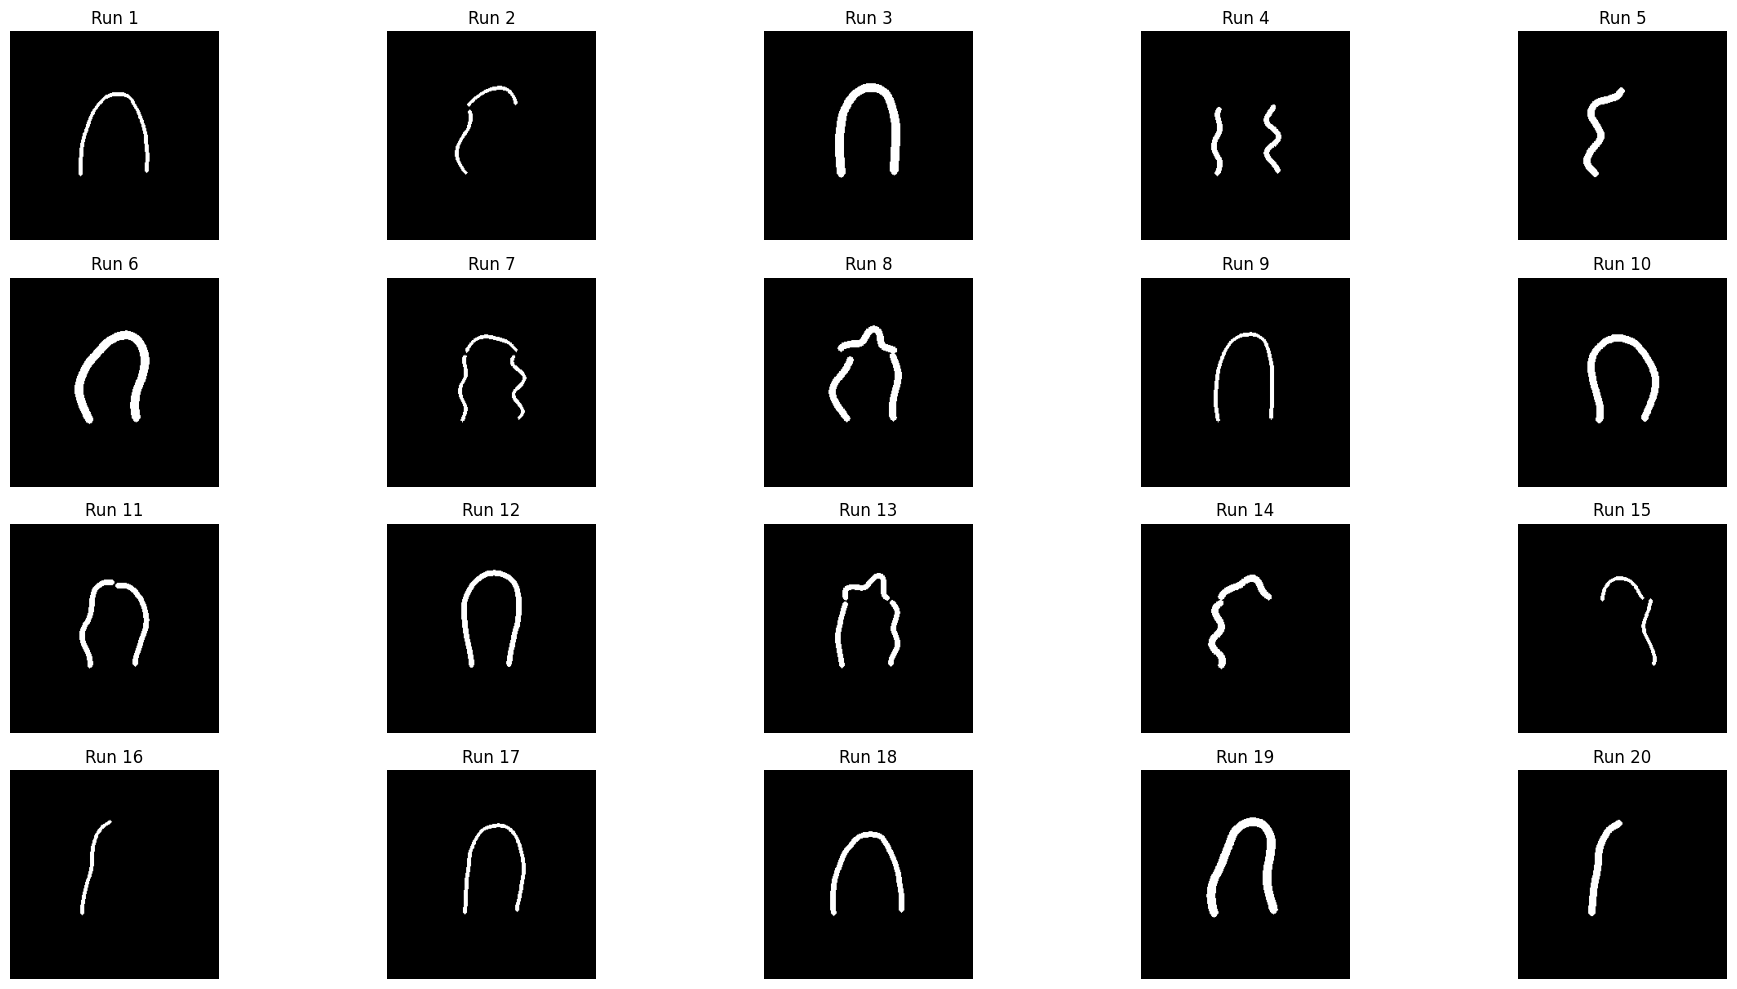

In [2]:
# Load mask image in grayscale mode (0-255 intensity values)
mask = cv2.imread("Patient001_slice001time001.png", cv2.IMREAD_GRAYSCALE)

# Convert white pixels (255) to label 1
#   - This assumes binary mask format: background=0, foreground=255
mask[mask == 255] = 1

# ---------------------------------------------------------------------------------
# Parameters for generate_scribble_segments():
# mask (np.ndarray)          : 2D binary mask input (values 0/1)
# target_label (int)         : Label value in the mask to generate scribble for
# segment_num (Tuple[int,int]): Range of number of path segments to split the skeleton into
# wave_num (Tuple[int,int])  : Range of sinusoidal wave counts per segment
# amp_frac (Tuple[float,float]): Amplitude factor range (scaled by distance transform)
# max_hide (int)             : Maximum number of segments to randomly omit
# resample_step (int)        : Path resampling step size in pixels
# min_amp_px (float)         : Minimum absolute offset threshold (in pixels)
# smooth_sigma (float)       : Gaussian smoothing sigma for final path
# line_width (int or Tuple[int,int]): Fixed or random stroke thickness in pixels
# ---------------------------------------------------------------------------------

plt.figure(figsize=(20, 10))  # Create figure for visualizing multiple runs

# Generate and visualize 20 random scribble variants
for i in range(20):
    scribble = generate_scribble_segments(
        mask,
        target_label=200,
        segment_num=(1, 3),
        wave_num=(1, 2),
        amp_frac=(0.1, 1.8),
        max_hide=1,
        resample_step=2,
        min_amp_px=1.0,
        smooth_sigma=3.0,
        line_width=(3, 10)
    )

    # Plot each scribble in a 4x5 grid
    plt.subplot(4, 5, i + 1)
    plt.imshow(scribble, cmap='gray')        # Show binary scribble mask
    plt.title(f'Run {i+1}')                  # Indicate run number
    plt.axis('off')                          # Hide axes for cleaner display

plt.tight_layout()                           # Adjust spacing between subplots
plt.show()                                   # Display the figure


In [3]:
# Print how many GPUs are visible to PyTorch
print('How many GPUs = ' + str(torch.cuda.device_count()))

# Select device: first GPU if available, otherwise fallback to CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)  # Show which device is selected

# If no GPU is available, stop execution (CPU training would be too slow)
if not torch.cuda.is_available():
    raise Exception("GPU not available. CPU training will be too slow.")

# Print the name/model of the first GPU
print("device name", torch.cuda.get_device_name(0))


How many GPUs = 2
cuda:0
device name NVIDIA RTX A6000


In [4]:
# Name for saving model checkpoints and outputs
saveFile = 'SCOPENet_Scribble'

# Path to the dataset directory (radial echocardiography data)
data_dir = '/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/'
print(data_dir)  # Print dataset path for confirmation

# Full path/filename for saving the trained model checkpoint
checkpoint_path = saveFile + '.pth'


/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/


In [5]:
# ======================
# Data Augmentation Pipelines (Albumentations)
# ======================

# --- Geometric augmentations ---
geo_aug = A.OneOf([  # Randomly choose ONE of the following transformations
    A.HorizontalFlip(p=0.1),         # Flip horizontally with 10% probability
    A.Rotate(limit=10, p=1.0)        # Rotate randomly within ±10 degrees
], p=0.6)                            # Apply one of them with 60% probability overall

# --- Photometric augmentations ---
photo_aug = A.SomeOf([  # Randomly choose a fixed number (n=1) of these augmentations
    A.MultiplicativeNoise(           # Apply multiplicative Gaussian noise
        multiplier=(0.8, 1.2),       # Scale factor range per pixel
        per_channel=True,            # Different noise per channel
        elementwise=True,            # Different noise per pixel
        p=1.0
    ),
    A.RandomBrightnessContrast(      # Adjust brightness and contrast
        brightness_limit=0.2,        # ±20% brightness change
        contrast_limit=0.2,          # ±20% contrast change
        p=1.0
    )
], n=1, p=0.6)                       # Choose 1 of them with 60% probability overall

# --- Training transform pipeline ---
transform = A.Compose([
    # Crop and resize while maintaining aspect ratio
    A.RandomResizedCrop(
        height=config.img_size,
        width=config.img_size,
        scale=(0.8, 1.0),
        p=1.0
    ),

    geo_aug,  # Apply geometric augmentations

    # Randomly mask out rectangular regions (like Cutout)
    A.CoarseDropout(
        max_holes=2,
        max_height=60, max_width=60,
        min_height=20, min_width=20,
        fill_value=0,
        p=0.4
    ),

    photo_aug,  # Apply photometric augmentations

    # Randomly apply blur
    A.OneOf([
        A.GaussianBlur(blur_limit=7, sigma_limit=(0.1, 2.0), p=1.0),
        A.MotionBlur(blur_limit=(3, 5), p=1.0)
    ], p=0.2),

    # Normalize to mean=0.5, std=0.5 (grayscale)
    A.Normalize(mean=[0.5], std=[0.5]),

    # Convert to PyTorch tensor (also transpose mask dims)
    ToTensorV2(transpose_mask=True)
],
    additional_targets={'scribble': 'mask'}  # Treat 'scribble' key as a mask for augmentation
)

# --- Test transform pipeline (no heavy augmentation) ---
transform_test = A.Compose([
    A.Resize(height=config.img_size, width=config.img_size),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2(transpose_mask=True)
],
    additional_targets={'scribble': 'mask'}
)

# --- Validation transform pipeline (same as test) ---
transform_val = A.Compose([
    A.Resize(height=config.img_size, width=config.img_size),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2(transpose_mask=True)
],
    additional_targets={'scribble': 'mask'}
)


In [6]:
# ======================
# Load dataset splits
# ======================

# --- Training set ---
# Collect all complete volumes (image–mask pairs with all slices present)
train_imgs, train_msks = collect_complete_volumes(
    data_dir,
    split="train"
)

# --- Validation set ---
val_imgs, val_msks = collect_complete_volumes(
    data_dir,
    split="val"
)

# --- Test set ---
# Here test set is kept separate (not merged with validation)
test_imgs, test_msks = collect_complete_volumes(
    data_dir,
    split="test"
)

# ======================
# Dataset summary
# ======================
# Verify the number of complete volumes and slice counts for each split
summary("train", train_imgs, train_msks)
summary("val",   val_imgs,   val_msks)
summary("test",  test_imgs,  test_msks)


Total volumes (train): 1478
Total volumes (val): 189
Total volumes (test): 178
train: 1478 complete volumes ✔️
val: 189 complete volumes ✔️
test: 178 complete volumes ✔️


In [7]:
# ======================
# Map patient IDs → list of (time index, dataset index)
# ======================
patient2indices = defaultdict(list)

# Loop through all training volumes
for ds_idx, imgs in enumerate(train_imgs):
    pid, t_idx = get_pid_time(imgs[0])  # Extract patient ID and time index from first slice filename
    patient2indices[pid].append((t_idx, ds_idx))  # Append tuple (time index, dataset index)

# Sort each patient's list of volumes by time index (chronological order)
for pid in patient2indices:
    patient2indices[pid].sort(key=lambda x: x[0])

# ======================
# Custom batch sampler for temporal windows
# ======================
sampler = NeighborTimeBatchSampler(
    patient2indices,
    window_size=config.window_size,      # e.g. 5 phases per batch
    stride=config.stride,                # e.g. overlap by 3 phases: [t0–t4], [t2–t6], …
    shuffle_patients=True,               # Shuffle patient order each epoch
    drop_last=False                      # Keep partial windows at the end
)

# ======================
# DataLoader without shuffling (temporal windows preserved)
# ======================
train_loader_noMIX = DataLoader(
    ReadChunkDatasetScribble(
        train_imgs,
        train_msks,
        transform=transform
    ),
    batch_sampler=sampler,                # Uses temporal neighbor sampler
    num_workers=config.num_workers,       # Parallel data loading
    pin_memory=True                       # Faster host-to-GPU transfer
)

# ======================
# DataLoader with shuffling (random mixing of samples)
# ======================
train_loader_MIX = DataLoader(
    ReadChunkDatasetScribble(
        train_imgs,
        train_msks,
        transform=transform
    ),
    batch_size=config.trainBatch,         # Fixed batch size
    shuffle=True,                          # Randomize order
    num_workers=config.num_workers
)

# ======================
# Inspect the first batch from the temporal-window loader
# ======================
for i, batch in enumerate(train_loader_noMIX):
    print(f'-------Batch={i}-----------')
    pid_set = {get_pid_time(p)[0] for p in batch['name'][0]}  # Unique patient IDs in batch
    times   = [get_pid_time(p)[1] for p in batch['name'][0]]  # Corresponding time indices
    print("patient(s) in first batch:", pid_set)
    print("time indices:", times[:config.window_size])
    print("image tensor shape:", batch['image'].shape)        # Shape: [B, 37, 1, H, W]
    print()
    print(batch['name'][0][0])                                # Path of first slice in batch
    break

# ======================
# Inspect the first batch from the random-mix loader
# ======================
for i, batch in enumerate(train_loader_MIX):
    print(f'-------Batch={i}-----------')
    pid_set = {get_pid_time(p)[0] for p in batch['name'][0]}
    times   = [get_pid_time(p)[1] for p in batch['name'][0]]
    print("patient(s) in first batch:", pid_set)
    print("time indices:", times[:config.window_size])
    print("image tensor shape:", batch['image'].shape)        # Shape: [B, 37, 1, H, W]
    print()
    print(batch['name'][0][0])
    break


-------Batch=0-----------
patient(s) in first batch: {'Patient035'}
time indices: [0, 1, 2, 3]
image tensor shape: torch.Size([4, 37, 1, 256, 256])

/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/train/image/Patient035/Patient035_slice001time001.png
-------Batch=0-----------
patient(s) in first batch: {'Patient008', 'Patient034', 'Patient032', 'Patient041'}
time indices: [25, 18, 6, 14]
image tensor shape: torch.Size([4, 37, 1, 256, 256])

/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/train/image/Patient008/Patient008_slice001time026.png


In [8]:
# ======================
# Test DataLoader (no shuffling, no strong augmentations)
# ======================
test_loader_MIX = DataLoader(
    ReadChunkDatasetScribble(
        test_imgs,
        test_msks,
        transform=transform_test    # Test-time transform (resize + normalize only)
    ),
    batch_size=config.testBatch,    # Number of volumes per batch during testing
    shuffle=False,                  # Keep test set order fixed (no shuffling)
    num_workers=config.num_workers  # Number of parallel data-loading workers
)

# ======================
# Inspect the first test batch
# ======================
for i, batch in enumerate(test_loader_MIX):
    print(f'-------Batch={i}-----------')

    # Extract unique patient IDs in this batch (from first slice in each volume)
    pid_set = {get_pid_time(p)[0] for p in batch['name'][0]}

    # Extract corresponding time indices for each volume
    times = [get_pid_time(p)[1] for p in batch['name'][0]]

    print("patient(s) in first batch:", pid_set)
    print("time indices:", times[:config.window_size])        # Show up to window_size frames

    # Show tensor shape: [B, 37 slices, 1 channel, H, W]
    print("image tensor shape:", batch['image'].shape)

    # Print path of the first slice in the first volume of this batch
    print()
    print(batch['name'][0][0])

    break  # Only inspect the first batch


-------Batch=0-----------
patient(s) in first batch: {'Patient017'}
time indices: [0]
image tensor shape: torch.Size([1, 37, 1, 256, 256])

/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/test/image/Patient017/Patient017_slice001time001.png


In [9]:
# ======================
# Validation DataLoader (with shuffling)
# ======================
val_loader_MIX = DataLoader(
    ReadChunkDatasetScribble(
        val_imgs,
        val_msks,
        transform=transform_val      # Validation transform (resize + normalize)
    ),
    batch_size=config.valBatch,      # Number of volumes per validation batch
    shuffle=True,                    # Shuffle order for validation batches
    num_workers=config.num_workers   # Parallel data loading workers
)

# ======================
# Inspect the first validation batch
# ======================
for i, batch in enumerate(val_loader_MIX):
    print(f'-------Batch={i}-----------')

    # Extract unique patient IDs from the batch
    pid_set = {get_pid_time(p)[0] for p in batch['name'][0]}

    # Extract corresponding time indices for each volume
    times = [get_pid_time(p)[1] for p in batch['name'][0]]

    print("patient(s) in first batch:", pid_set)
    print("time indices:", times[:config.window_size])         # Display only first window_size entries

    # Show tensor shape: [B, 37 slices, 1 channel, H, W]
    print("image tensor shape:", batch['image'].shape)

    # Print path to the first slice in the first volume
    print()
    print(batch['name'][0][0])

    break  # Stop after inspecting first batch


-------Batch=0-----------
patient(s) in first batch: {'Patient036', 'Patient033', 'Patient018'}
time indices: [1, 11, 27, 28]
image tensor shape: torch.Size([4, 37, 1, 256, 256])

/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/val/image/Patient036/Patient036_slice001time002.png


In [10]:
# Utility function: return the first batch from a DataLoader
def first(loader):
    return next(iter(loader))

# ======================
# Inspect a sample training batch
# ======================
train_sample = first(train_loader_MIX)
print("Train batch shapes:")
print("  image:    ", train_sample['image'].shape)     # Shape: [B, 37 slices, 1 channel, H, W]
print("  mask:     ", train_sample['mask'].shape)      # Same shape as image
print("  scribble: ", train_sample['scribble'].shape)  # Same shape as mask, scribble annotations
print("  names in volume 0:", train_sample['name'][0][:3], "...")  # First 3 slice filenames

# ======================
# Inspect a sample test batch
# ======================
test_sample = first(test_loader_MIX)
print("\nTest batch shapes:")
print("  image:    ", test_sample['image'].shape)
print("  mask:     ", test_sample['mask'].shape)
print("  scribble: ", test_sample['scribble'].shape)
print("  names in volume 0:", test_sample['name'][0][:3], "...")

# ======================
# Inspect a sample validation batch
# ======================
val_sample = first(val_loader_MIX)
print("\nVal batch shapes:")
print("  image:    ", val_sample['image'].shape)
print("  mask:     ", val_sample['mask'].shape)
print("  scribble: ", val_sample['scribble'].shape)
print("  names in volume 0:", val_sample['name'][0][:3], "...")

# ======================
# One-hot encode the masks from the test batch
# ======================
# Convert mask tensor [B, 37, 1, H, W] → one-hot encoding [B, 37, C, H, W]
#   - C=3: background + 2 foreground classes
one_hot_mask = make_one_hot(test_sample['mask'], device, C=3)
print(one_hot_mask.shape)  # Example: [4, 37, 3, 256, 256]


Train batch shapes:
  image:     torch.Size([4, 37, 1, 256, 256])
  mask:      torch.Size([4, 37, 1, 256, 256])
  scribble:  torch.Size([4, 37, 1, 256, 256])
  names in volume 0: ('/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/train/image/Patient022/Patient022_slice001time033.png', '/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/train/image/Patient012/Patient012_slice001time029.png', '/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/train/image/Patient030/Patient030_slice001time006.png') ...

Test batch shapes:
  image:     torch.Size([1, 37, 1, 256, 256])
  mask:      torch.Size([1, 37, 1, 256, 256])
  scribble:  torch.Size([1, 37, 1, 256, 256])
  names in volume 0: ('/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/test/image/Patient017/Patient017_slice001time001.png',) ...

Val batch shapes:
  image:     torch.Size([4, 37, 1, 256, 256])
  mask:      torch.Size([4, 37, 1, 256, 256])
  scribble:  torch.Size([4, 37, 1, 256, 256])
  names in volume 0: ('/home/dario/KAMR

/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/train/image/Patient020/Patient020_slice001time016.png


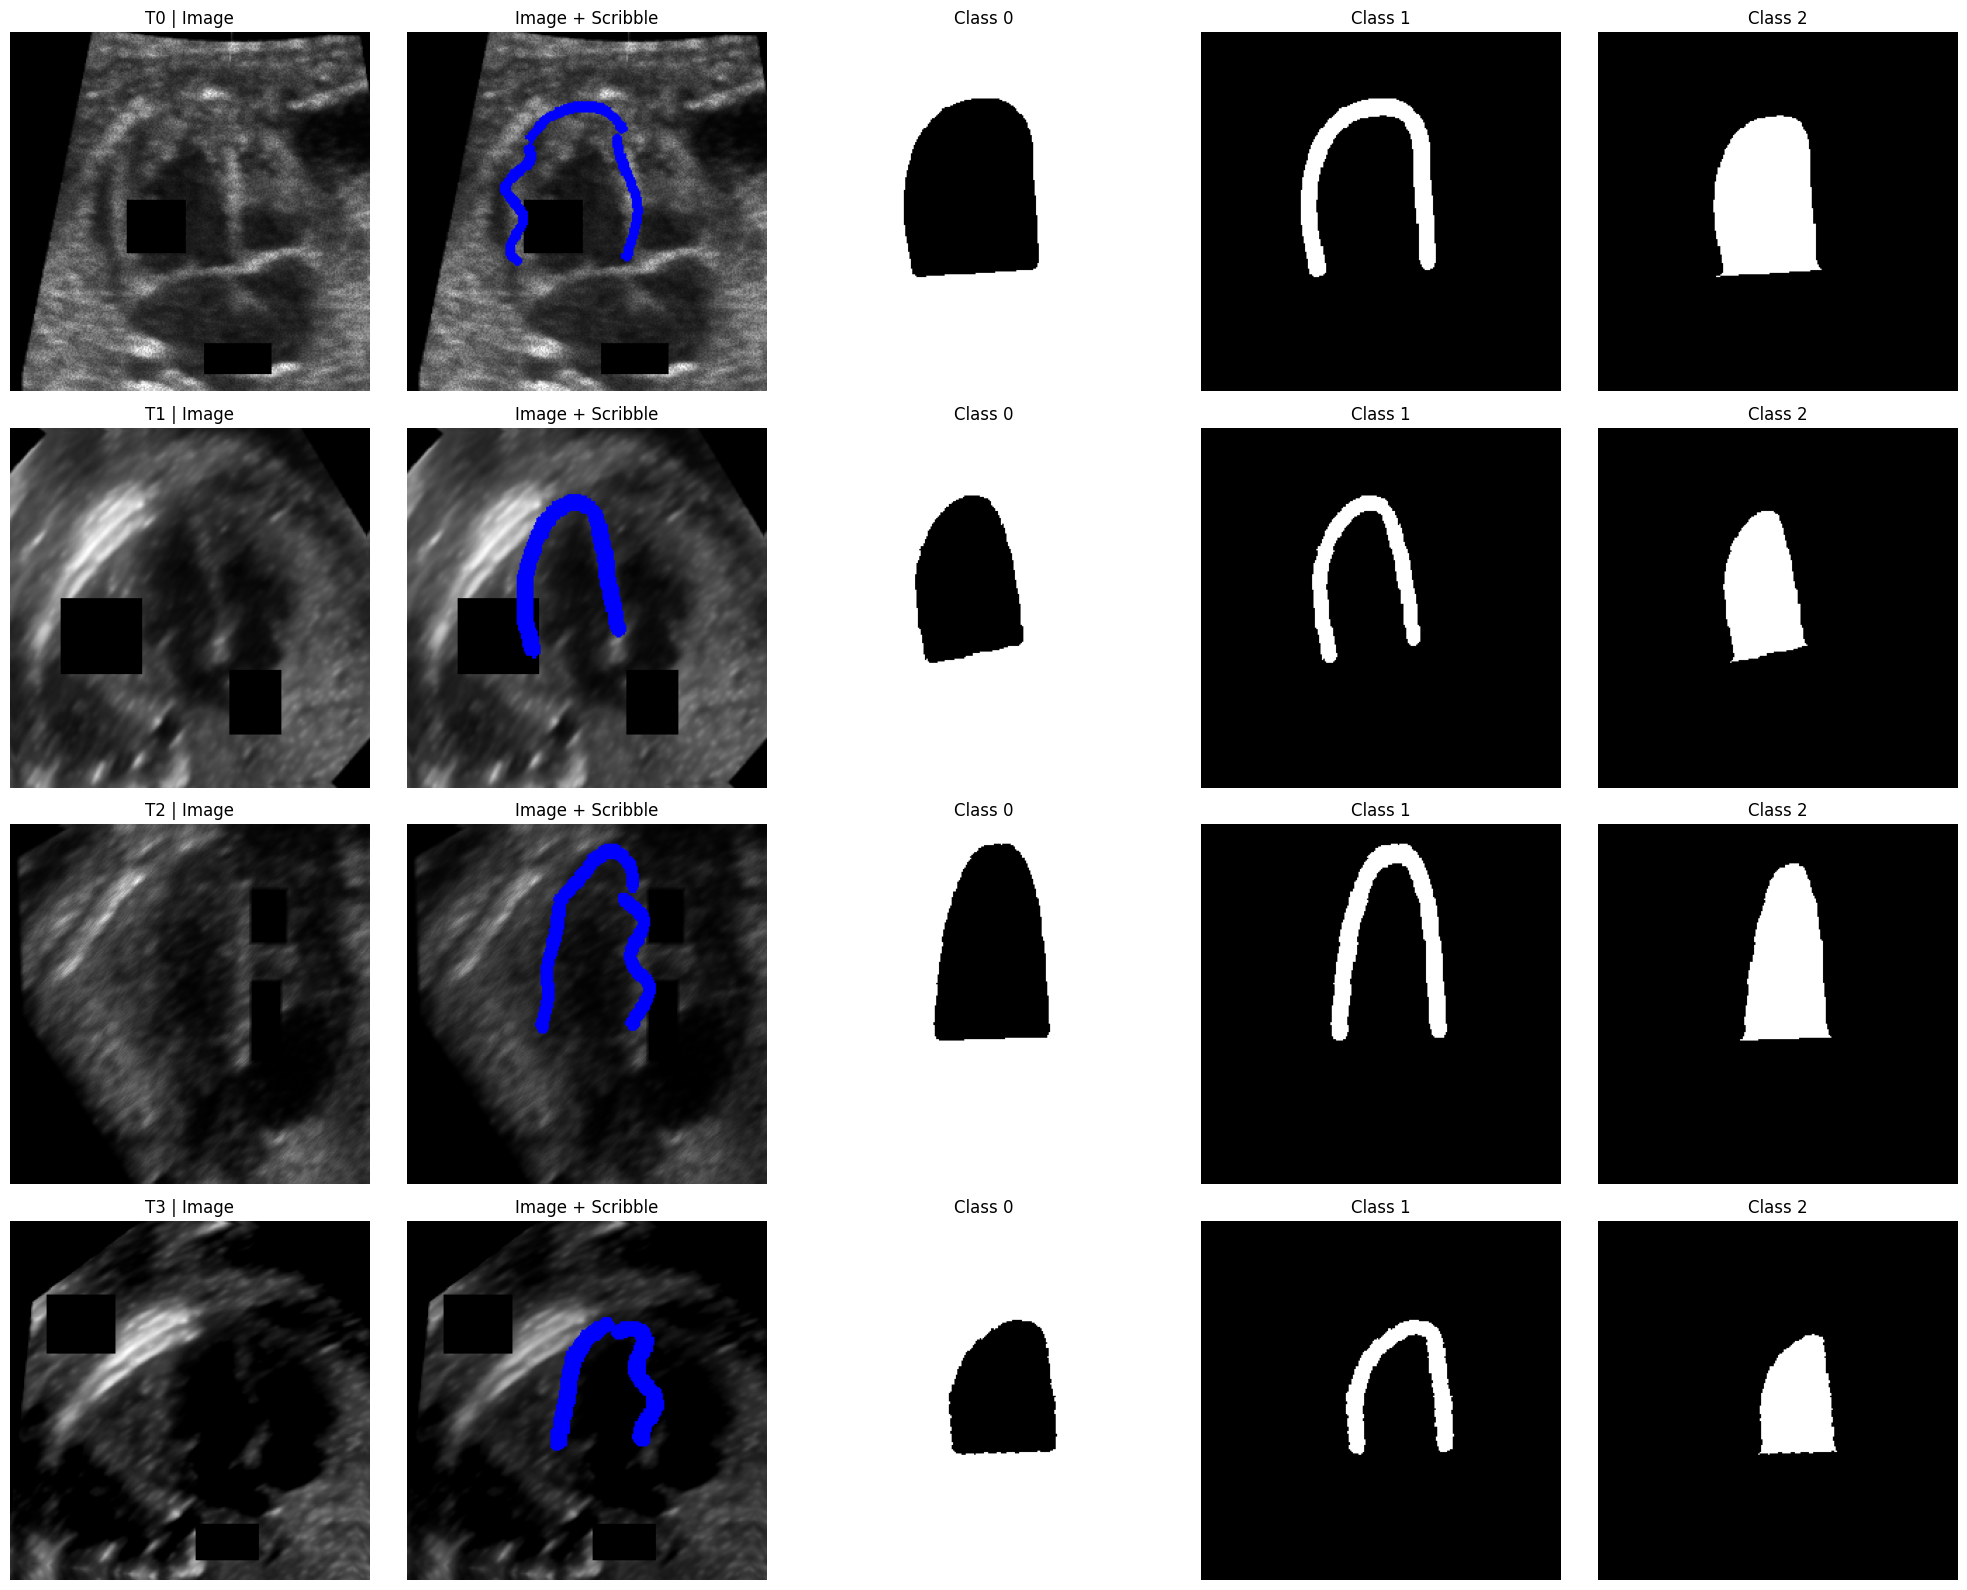

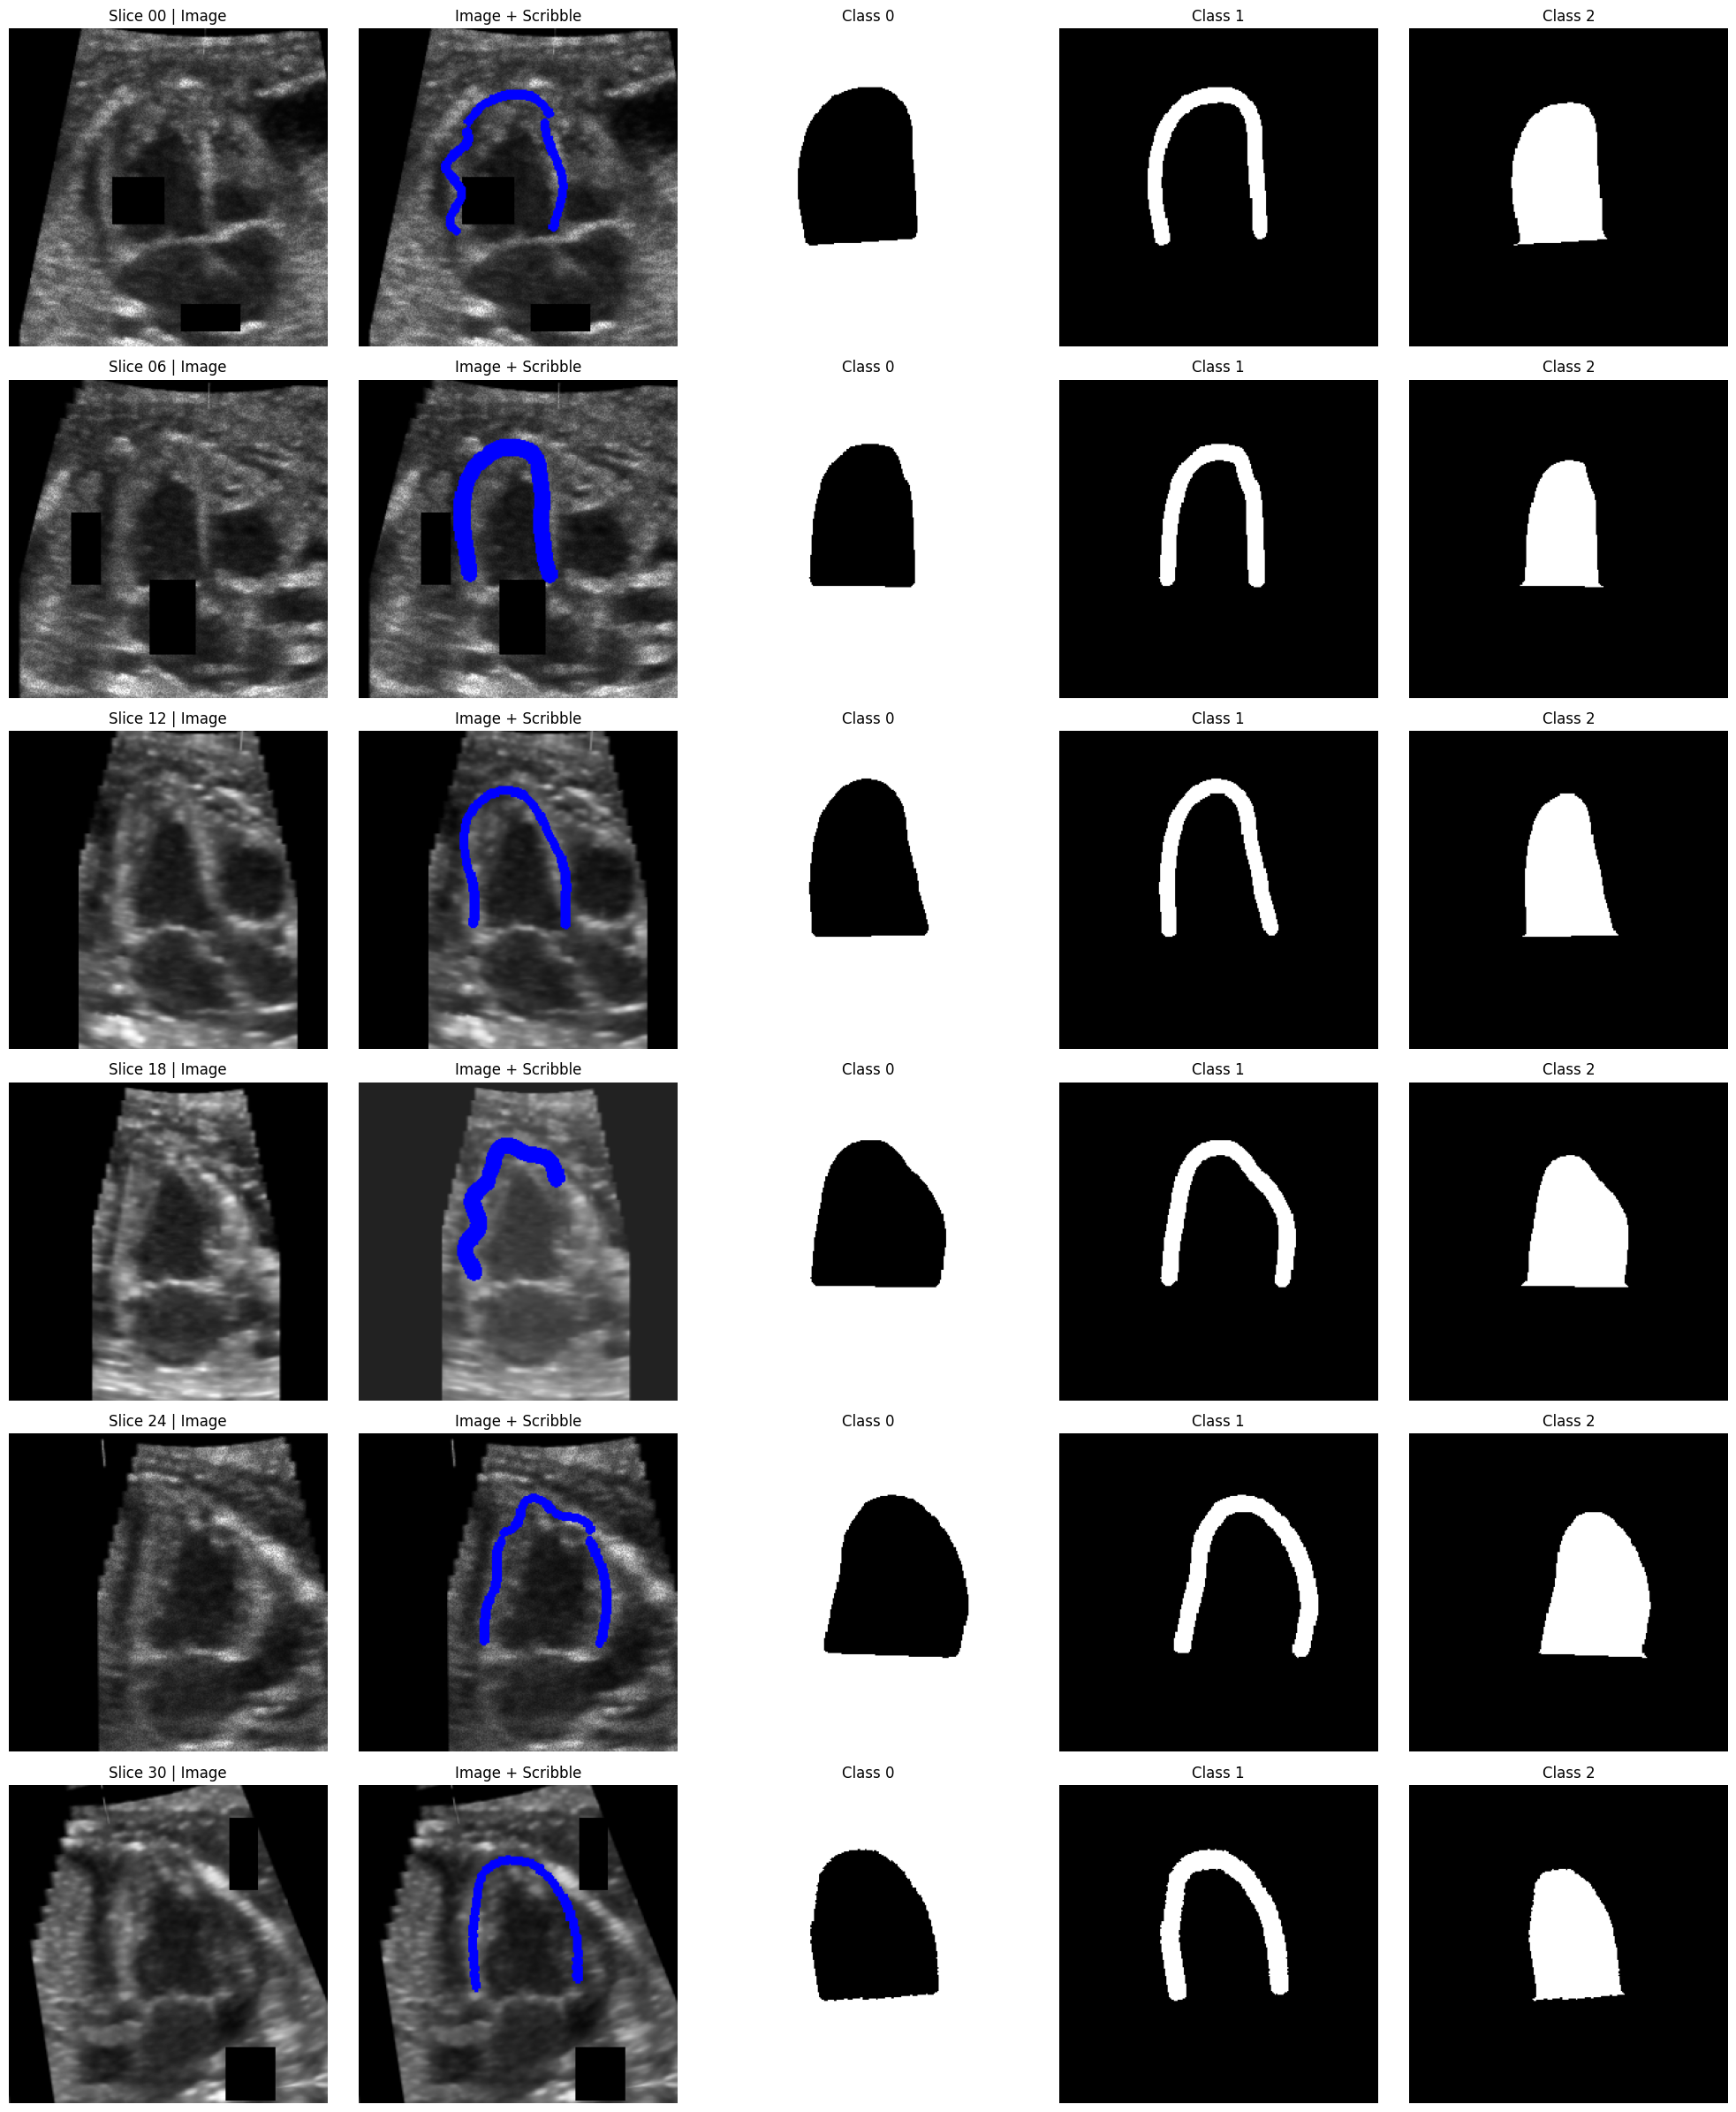

In [11]:
# -------------------------------------------------------------------
# Example: visualize scribble annotations for training data
# -------------------------------------------------------------------

# Get the first batch from the training loader
batch = next(iter(train_loader_MIX))   # Could also use: batch = first(train_loader_MIX)

# Print the filename of the first slice in the first volume
print(batch['name'][0][0])

# -------------------------------------------------
# Visualization #1: Single slice across all time frames
#   - slice_idx=0 → show the same spatial slice (0) for every time frame in the batch
#   - num_classes=config.num_classes → total segmentation classes
#   - device=device → where to run one-hot encoding
# -------------------------------------------------
show_time_slices_scribble(
    batch=batch,
    slice_idx=0,
    num_classes=config.num_classes,
    device=device
)

# -------------------------------------------------
# Visualization #2: Multiple slices from a single time frame
#   - volume_idx=0 → fix to first time frame (T0) in the batch
#   - slice_indices=[0, 6, 12, 18, 24, 30] → select subset of spatial slices (0–36)
# -------------------------------------------------
show_slices_scribble(
    batch=batch,
    volume_idx=0,                       # Choose a single time frame to display
    slice_indices=[0, 6, 12, 18, 24, 30], # Pick any subset of slice indices
    num_classes=config.num_classes,
    device=device
)


/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/train/image/Patient004/Patient004_slice001time001.png


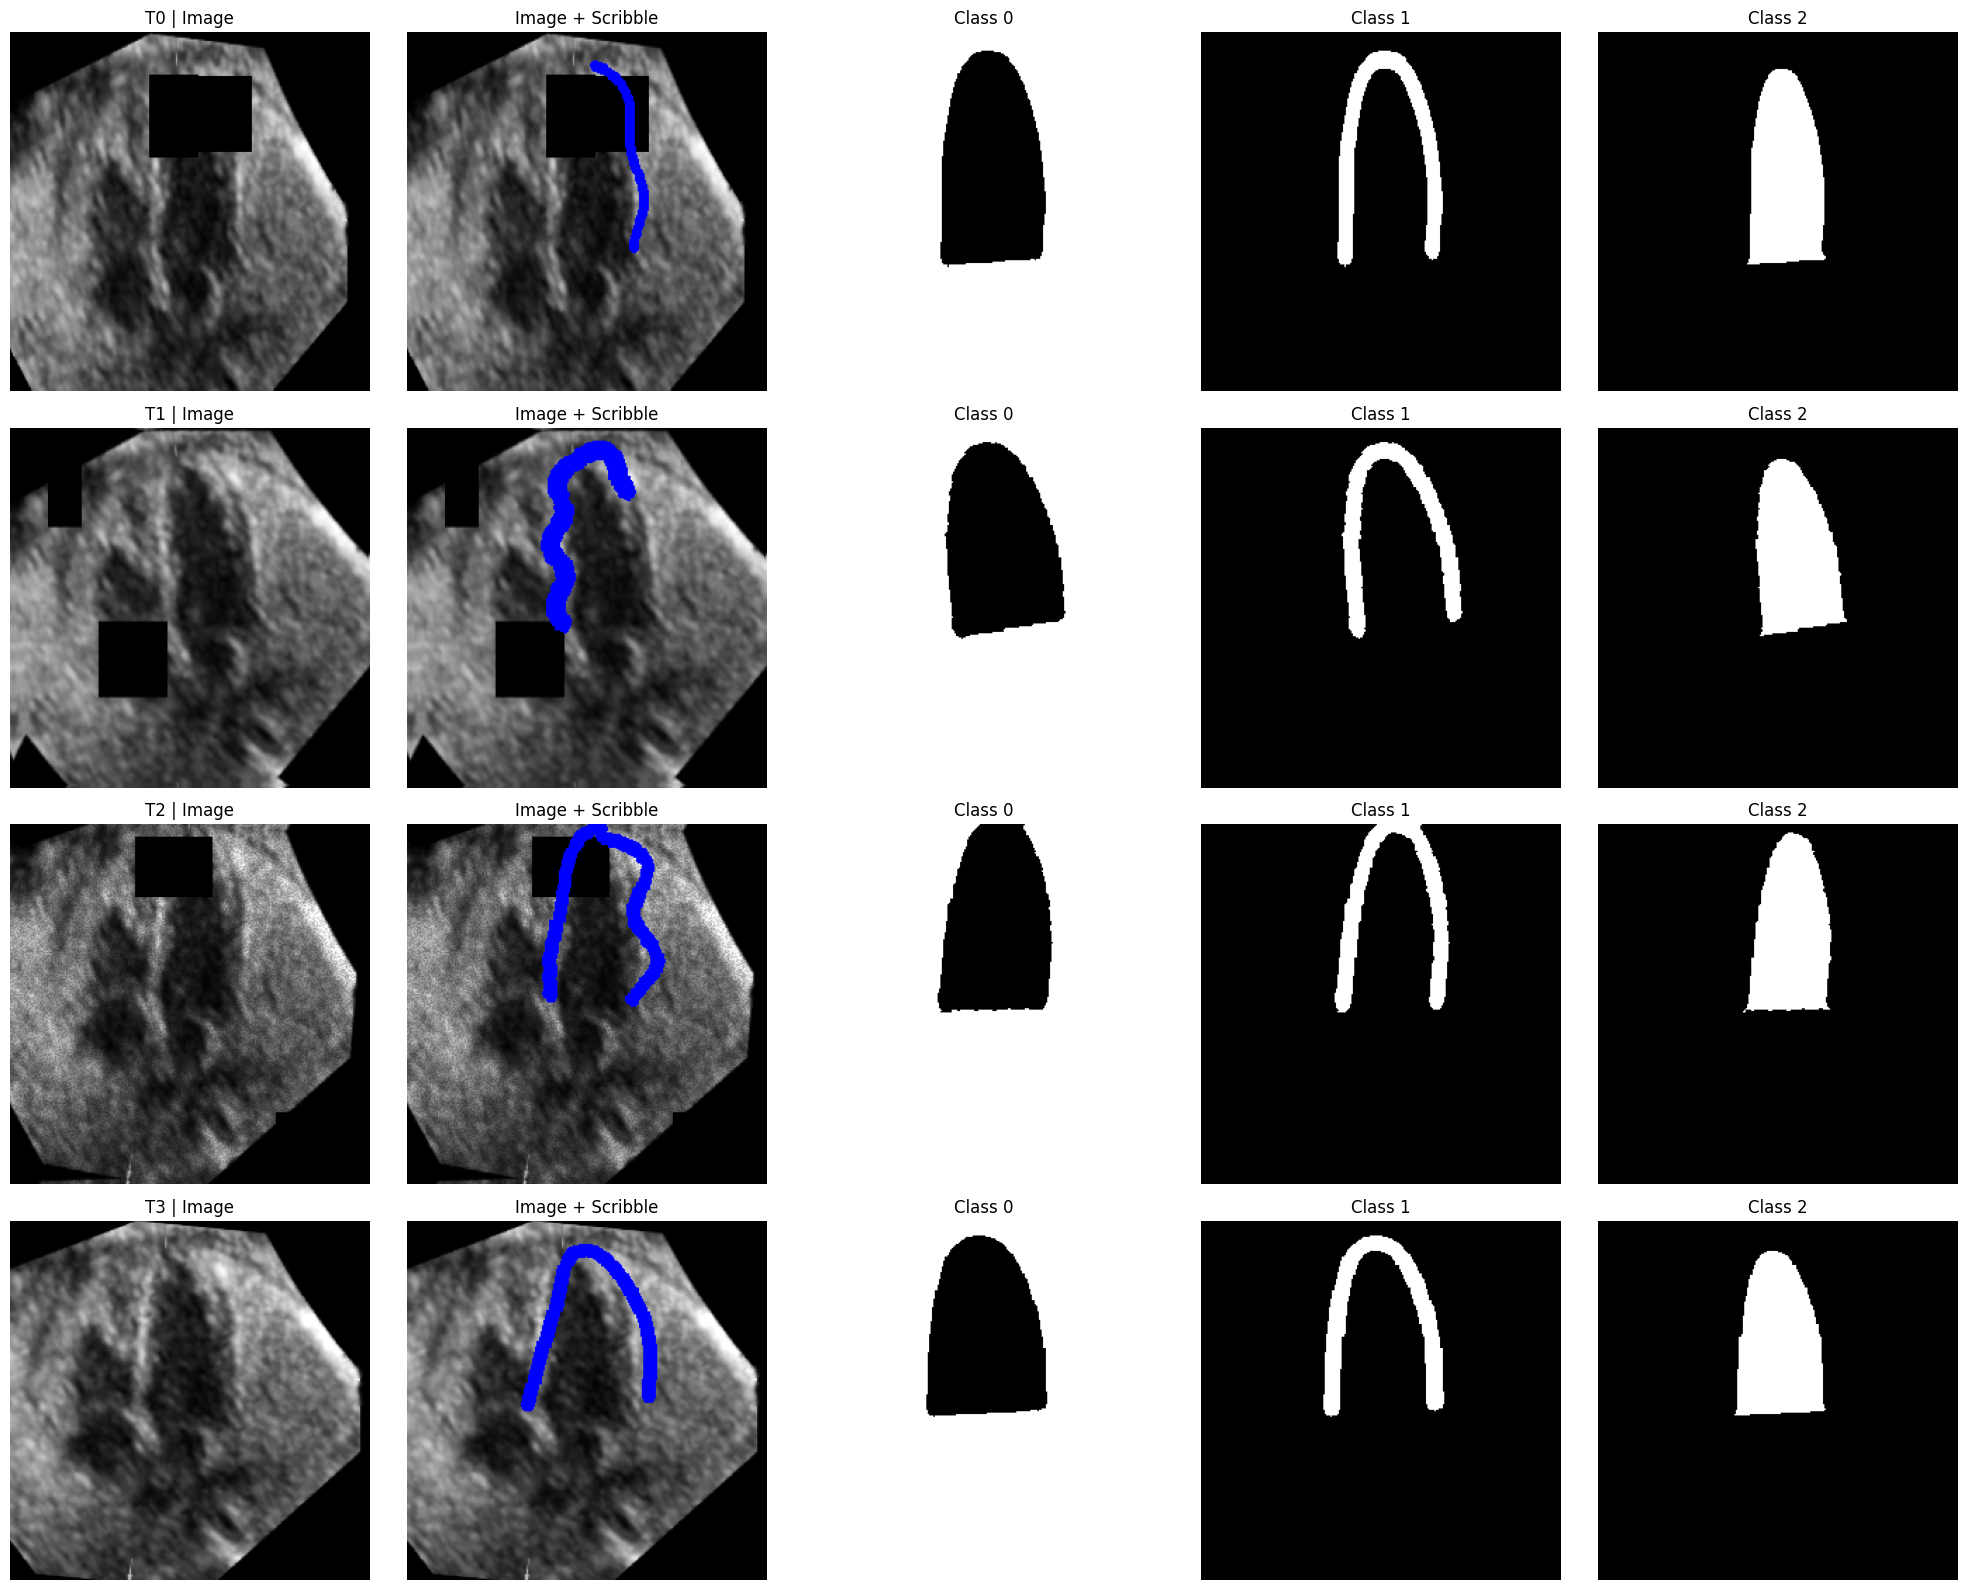

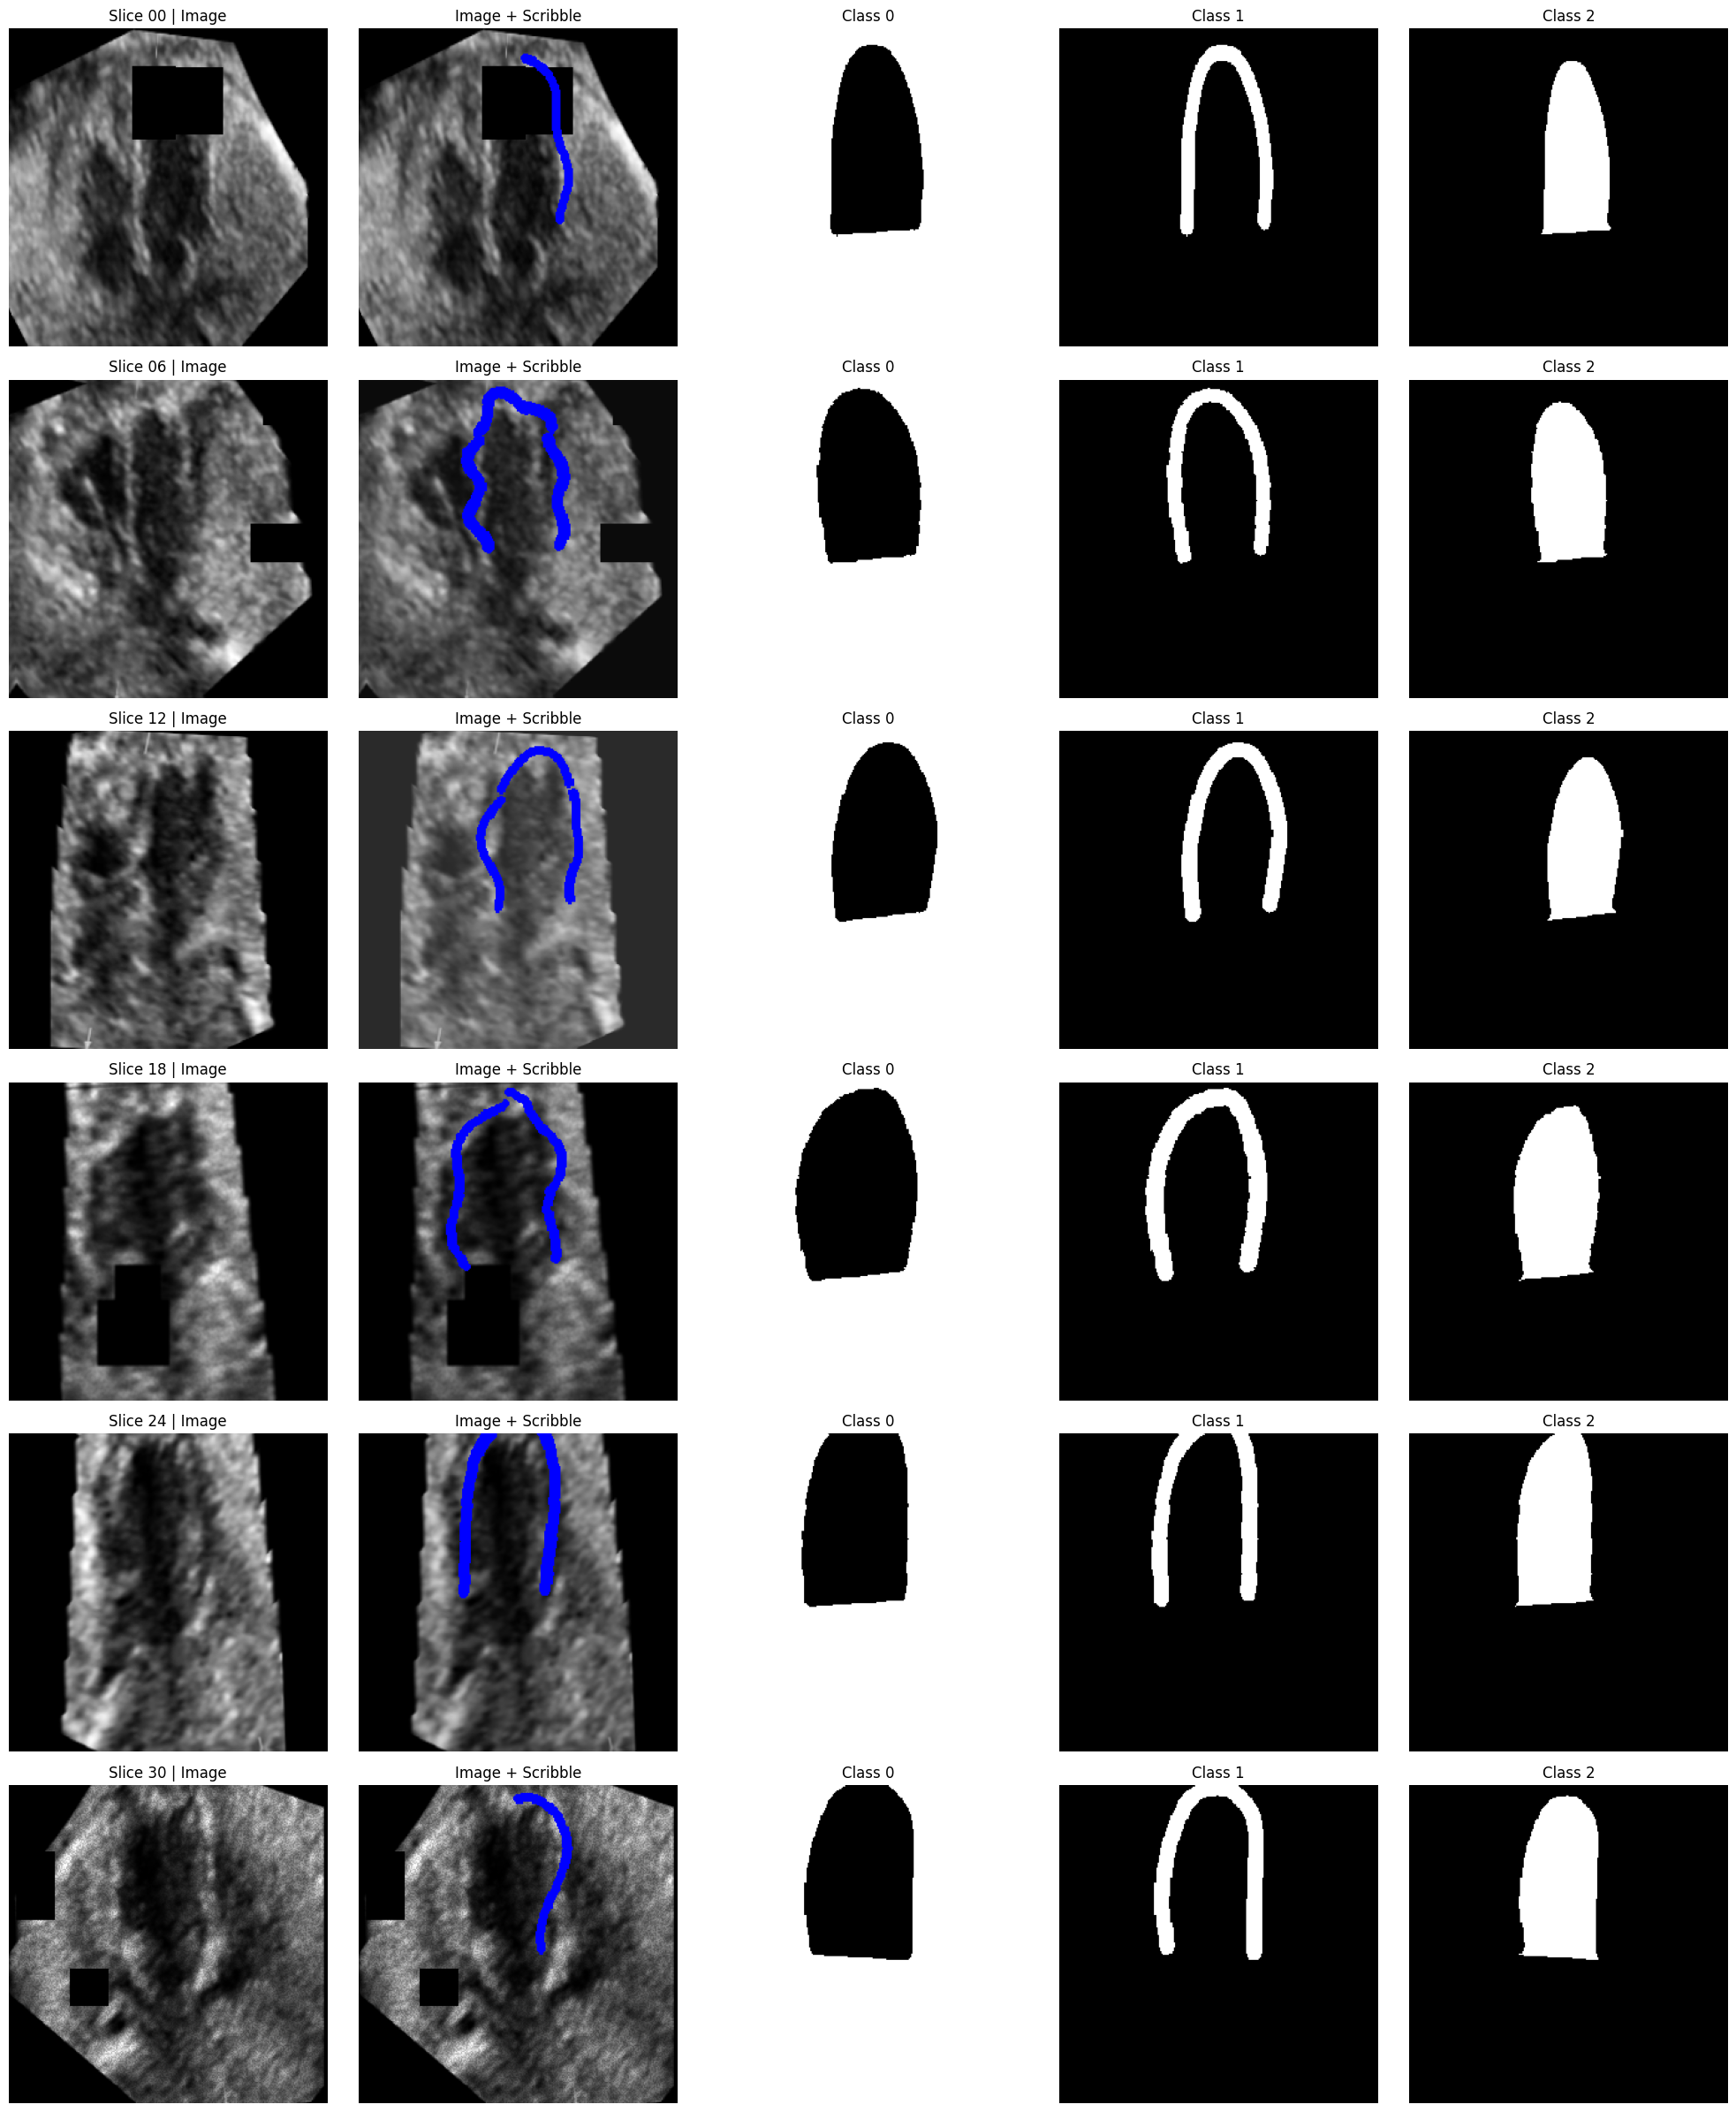

In [12]:
# -------------------------------------------------------------------
# Example: visualize scribble annotations for temporally ordered batches
# -------------------------------------------------------------------

# Get the first batch from the temporal-window training loader (no mixing of time frames)
batch = next(iter(train_loader_noMIX))   # Could also use: batch = first(train_loader_noMIX)

# Print the filename of the first slice in the first volume
print(batch['name'][0][0])

# -------------------------------------------------
# Visualization #1: Single spatial slice across all time frames
#   - slice_idx=0 → display the same radial slice index (0) for every time frame
#   - num_classes=config.num_classes → number of segmentation classes
#   - device=device → used for one-hot encoding inside the function
# -------------------------------------------------
show_time_slices_scribble(
    batch=batch,
    slice_idx=0,
    num_classes=config.num_classes,
    device=device
)

# -------------------------------------------------
# Visualization #2: Multiple spatial slices from a single time frame
#   - volume_idx=0 → choose the first time frame in the batch
#   - slice_indices=[0, 6, 12, 18, 24, 30] → select subset of the 37 available slices
# -------------------------------------------------
show_slices_scribble(
    batch=batch,
    volume_idx=0,                        # Fix to one time frame (e.g., T0)
    slice_indices=[0, 6, 12, 18, 24, 30], # Pick any subset of slice IDs (0–36)
    num_classes=config.num_classes,
    device=device
)


/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/test/image/Patient017/Patient017_slice001time001.png


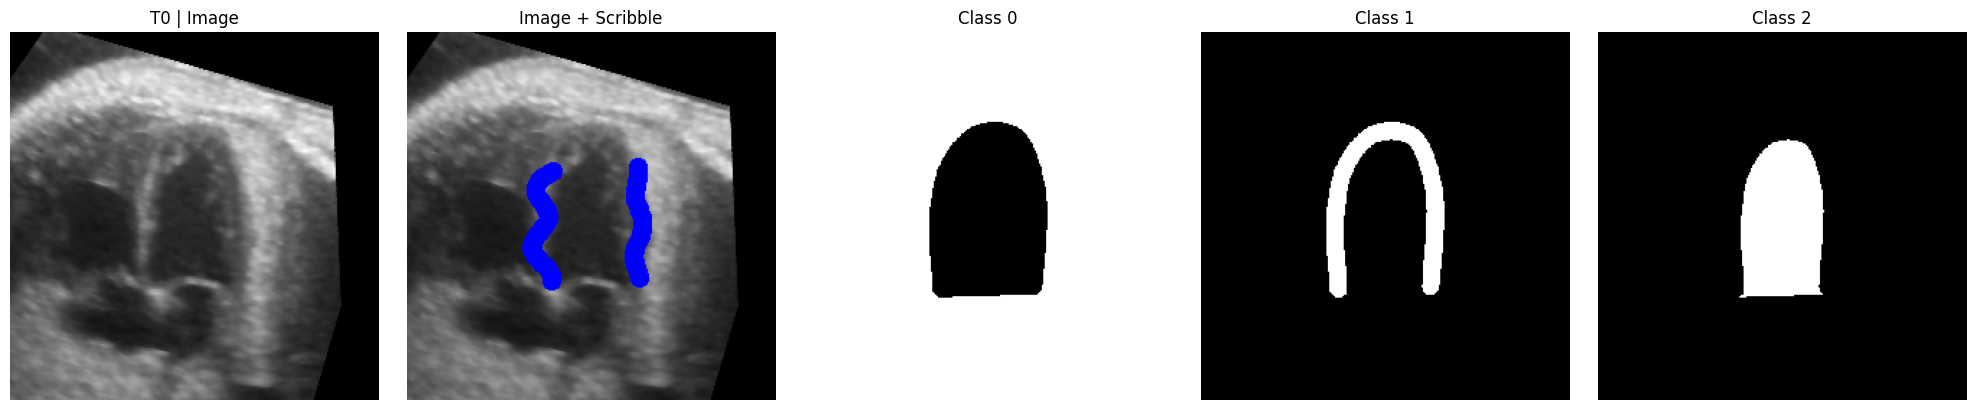

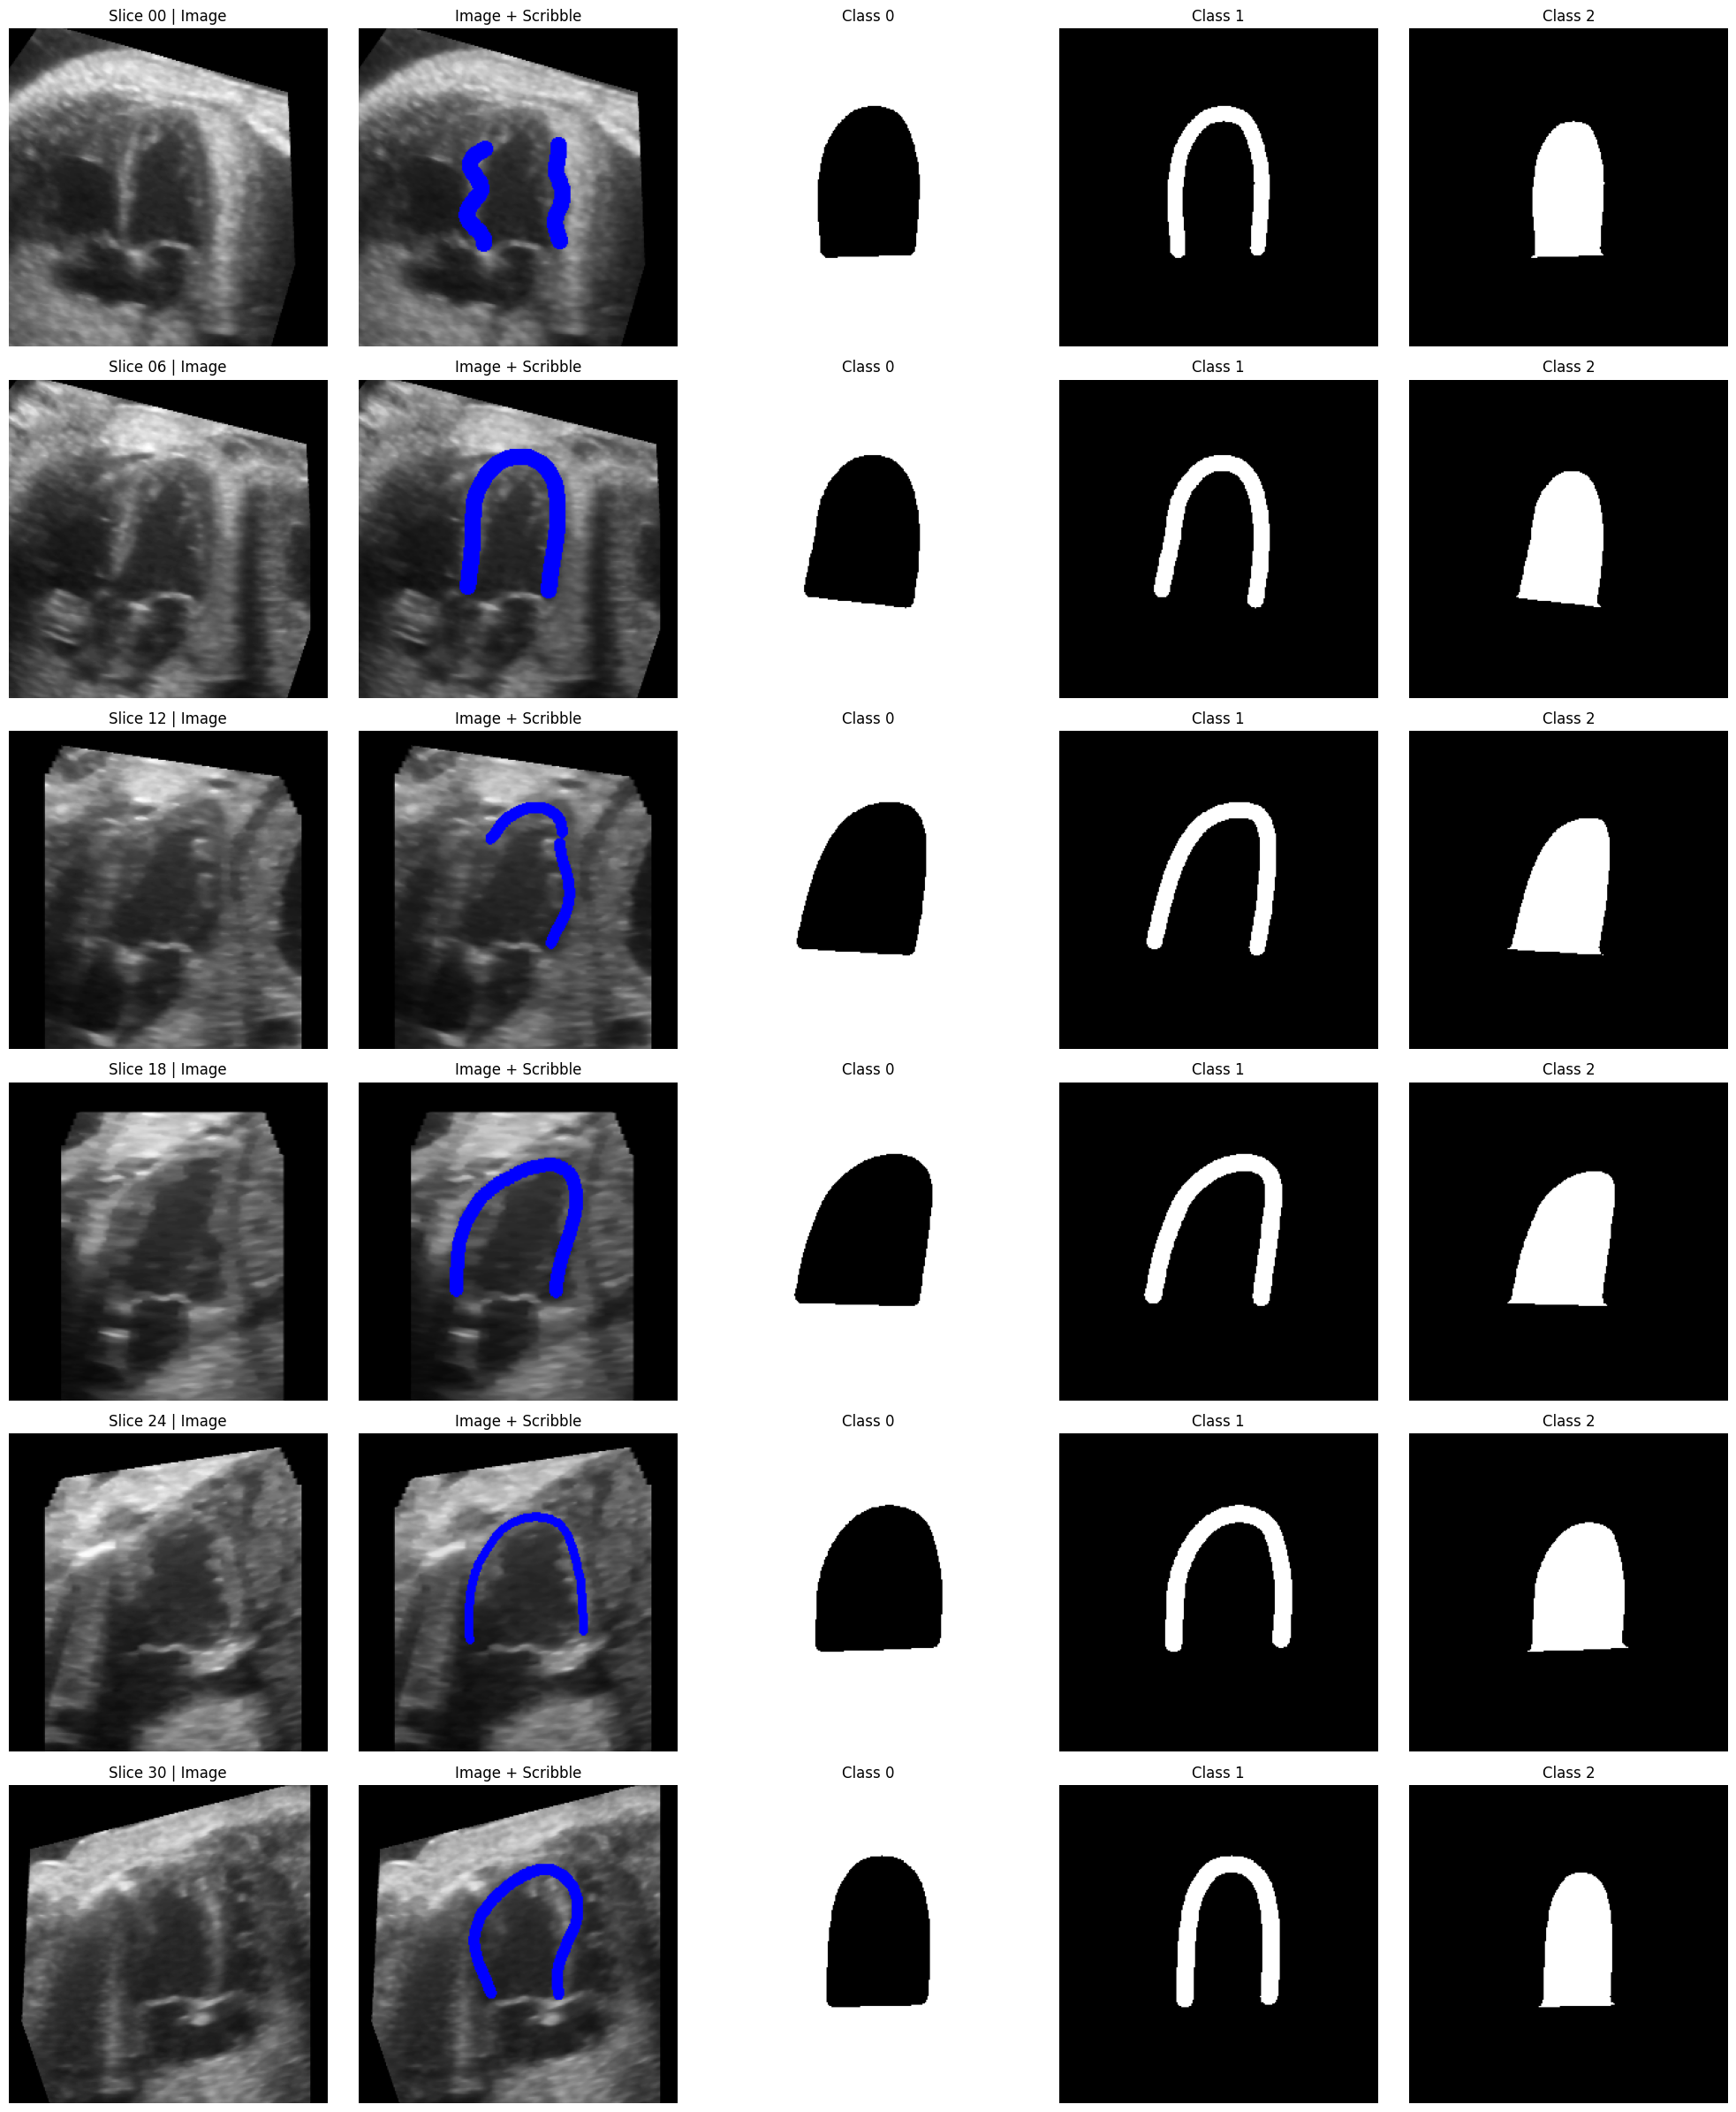

In [13]:
# -------------------------------------------------------------------
# Example: visualize scribble annotations for test data
# -------------------------------------------------------------------

# Get the first batch from the test loader
batch = next(iter(test_loader_MIX))   # Could also use: batch = first(test_loader_MIX)

# Print the filename of the first slice in the first volume of the batch
print(batch['name'][0][0])

# -------------------------------------------------
# Visualization #1: Single spatial slice across all time frames
#   - slice_idx=0 → show the same radial slice index (0) for each time frame
#   - num_classes=config.num_classes → total number of segmentation classes
#   - device=device → used for one-hot encoding inside the function
# -------------------------------------------------
show_time_slices_scribble(
    batch=batch,
    slice_idx=0,
    num_classes=config.num_classes,
    device=device
)

# -------------------------------------------------
# Visualization #2: Multiple spatial slices from a single time frame
#   - volume_idx=0 → fix to the first time frame (T0) in the batch
#   - slice_indices=[0, 6, 12, 18, 24, 30] → choose any subset of slices (0–36)
# -------------------------------------------------
show_slices_scribble(
    batch=batch,
    volume_idx=0,                        # Pick one time frame
    slice_indices=[0, 6, 12, 18, 24, 30], # Select a subset of slice IDs
    num_classes=config.num_classes,
    device=device
)


/home/dario/KAMRUL/Radial4D_Paper/data/FETAL_radial/val/image/Patient018/Patient018_slice001time026.png


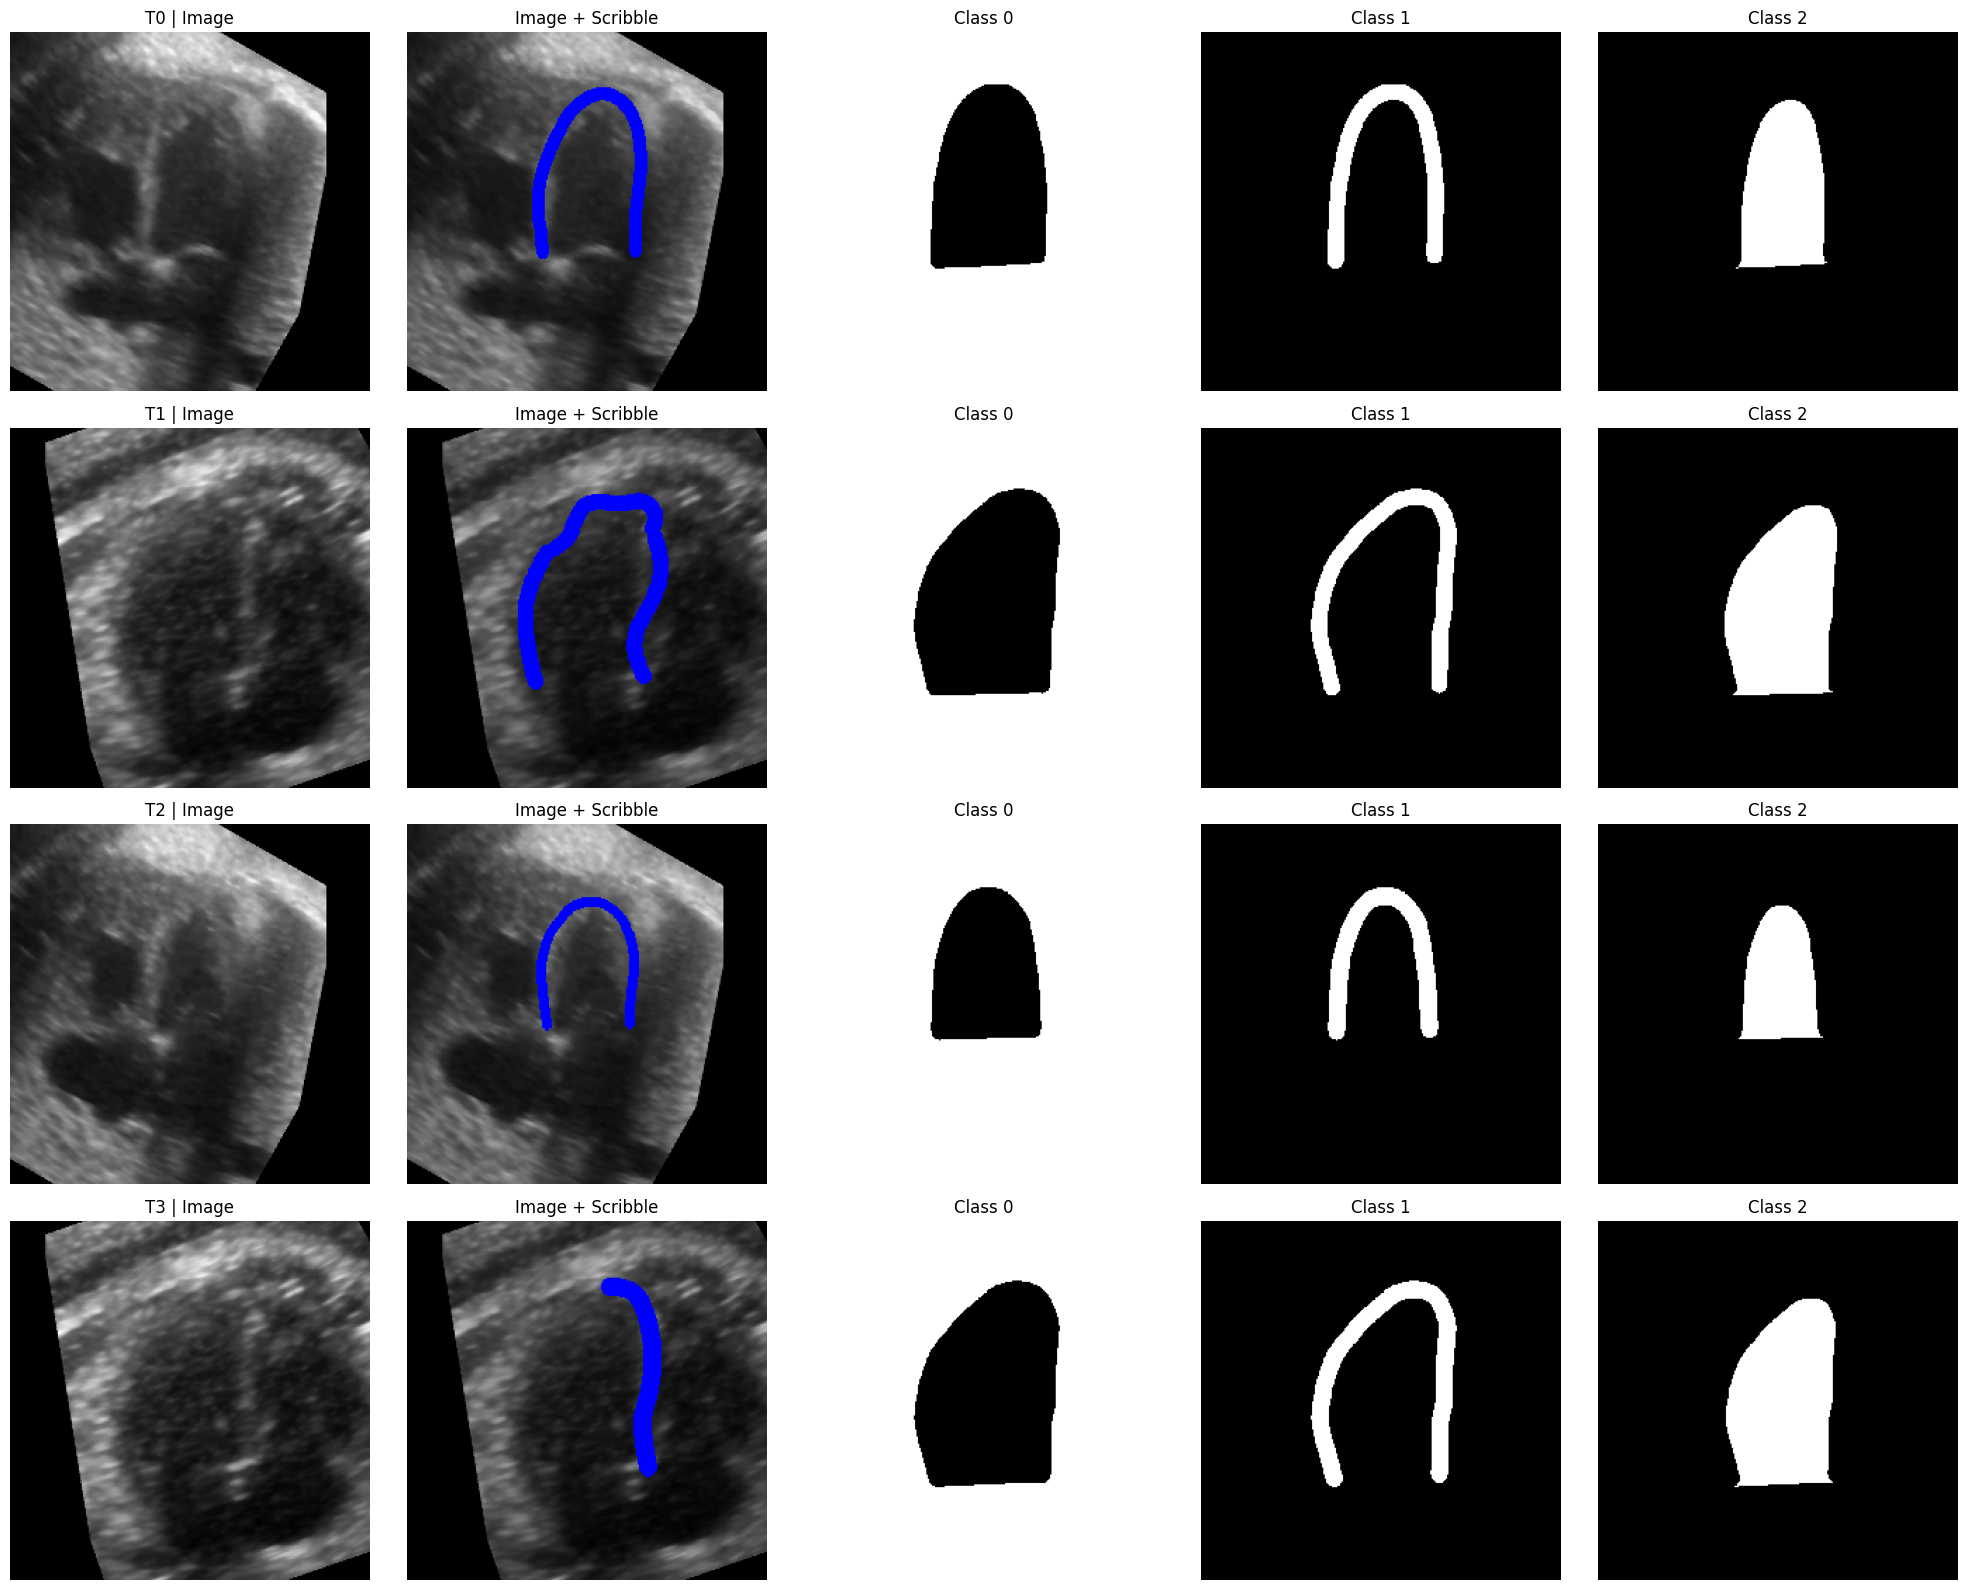

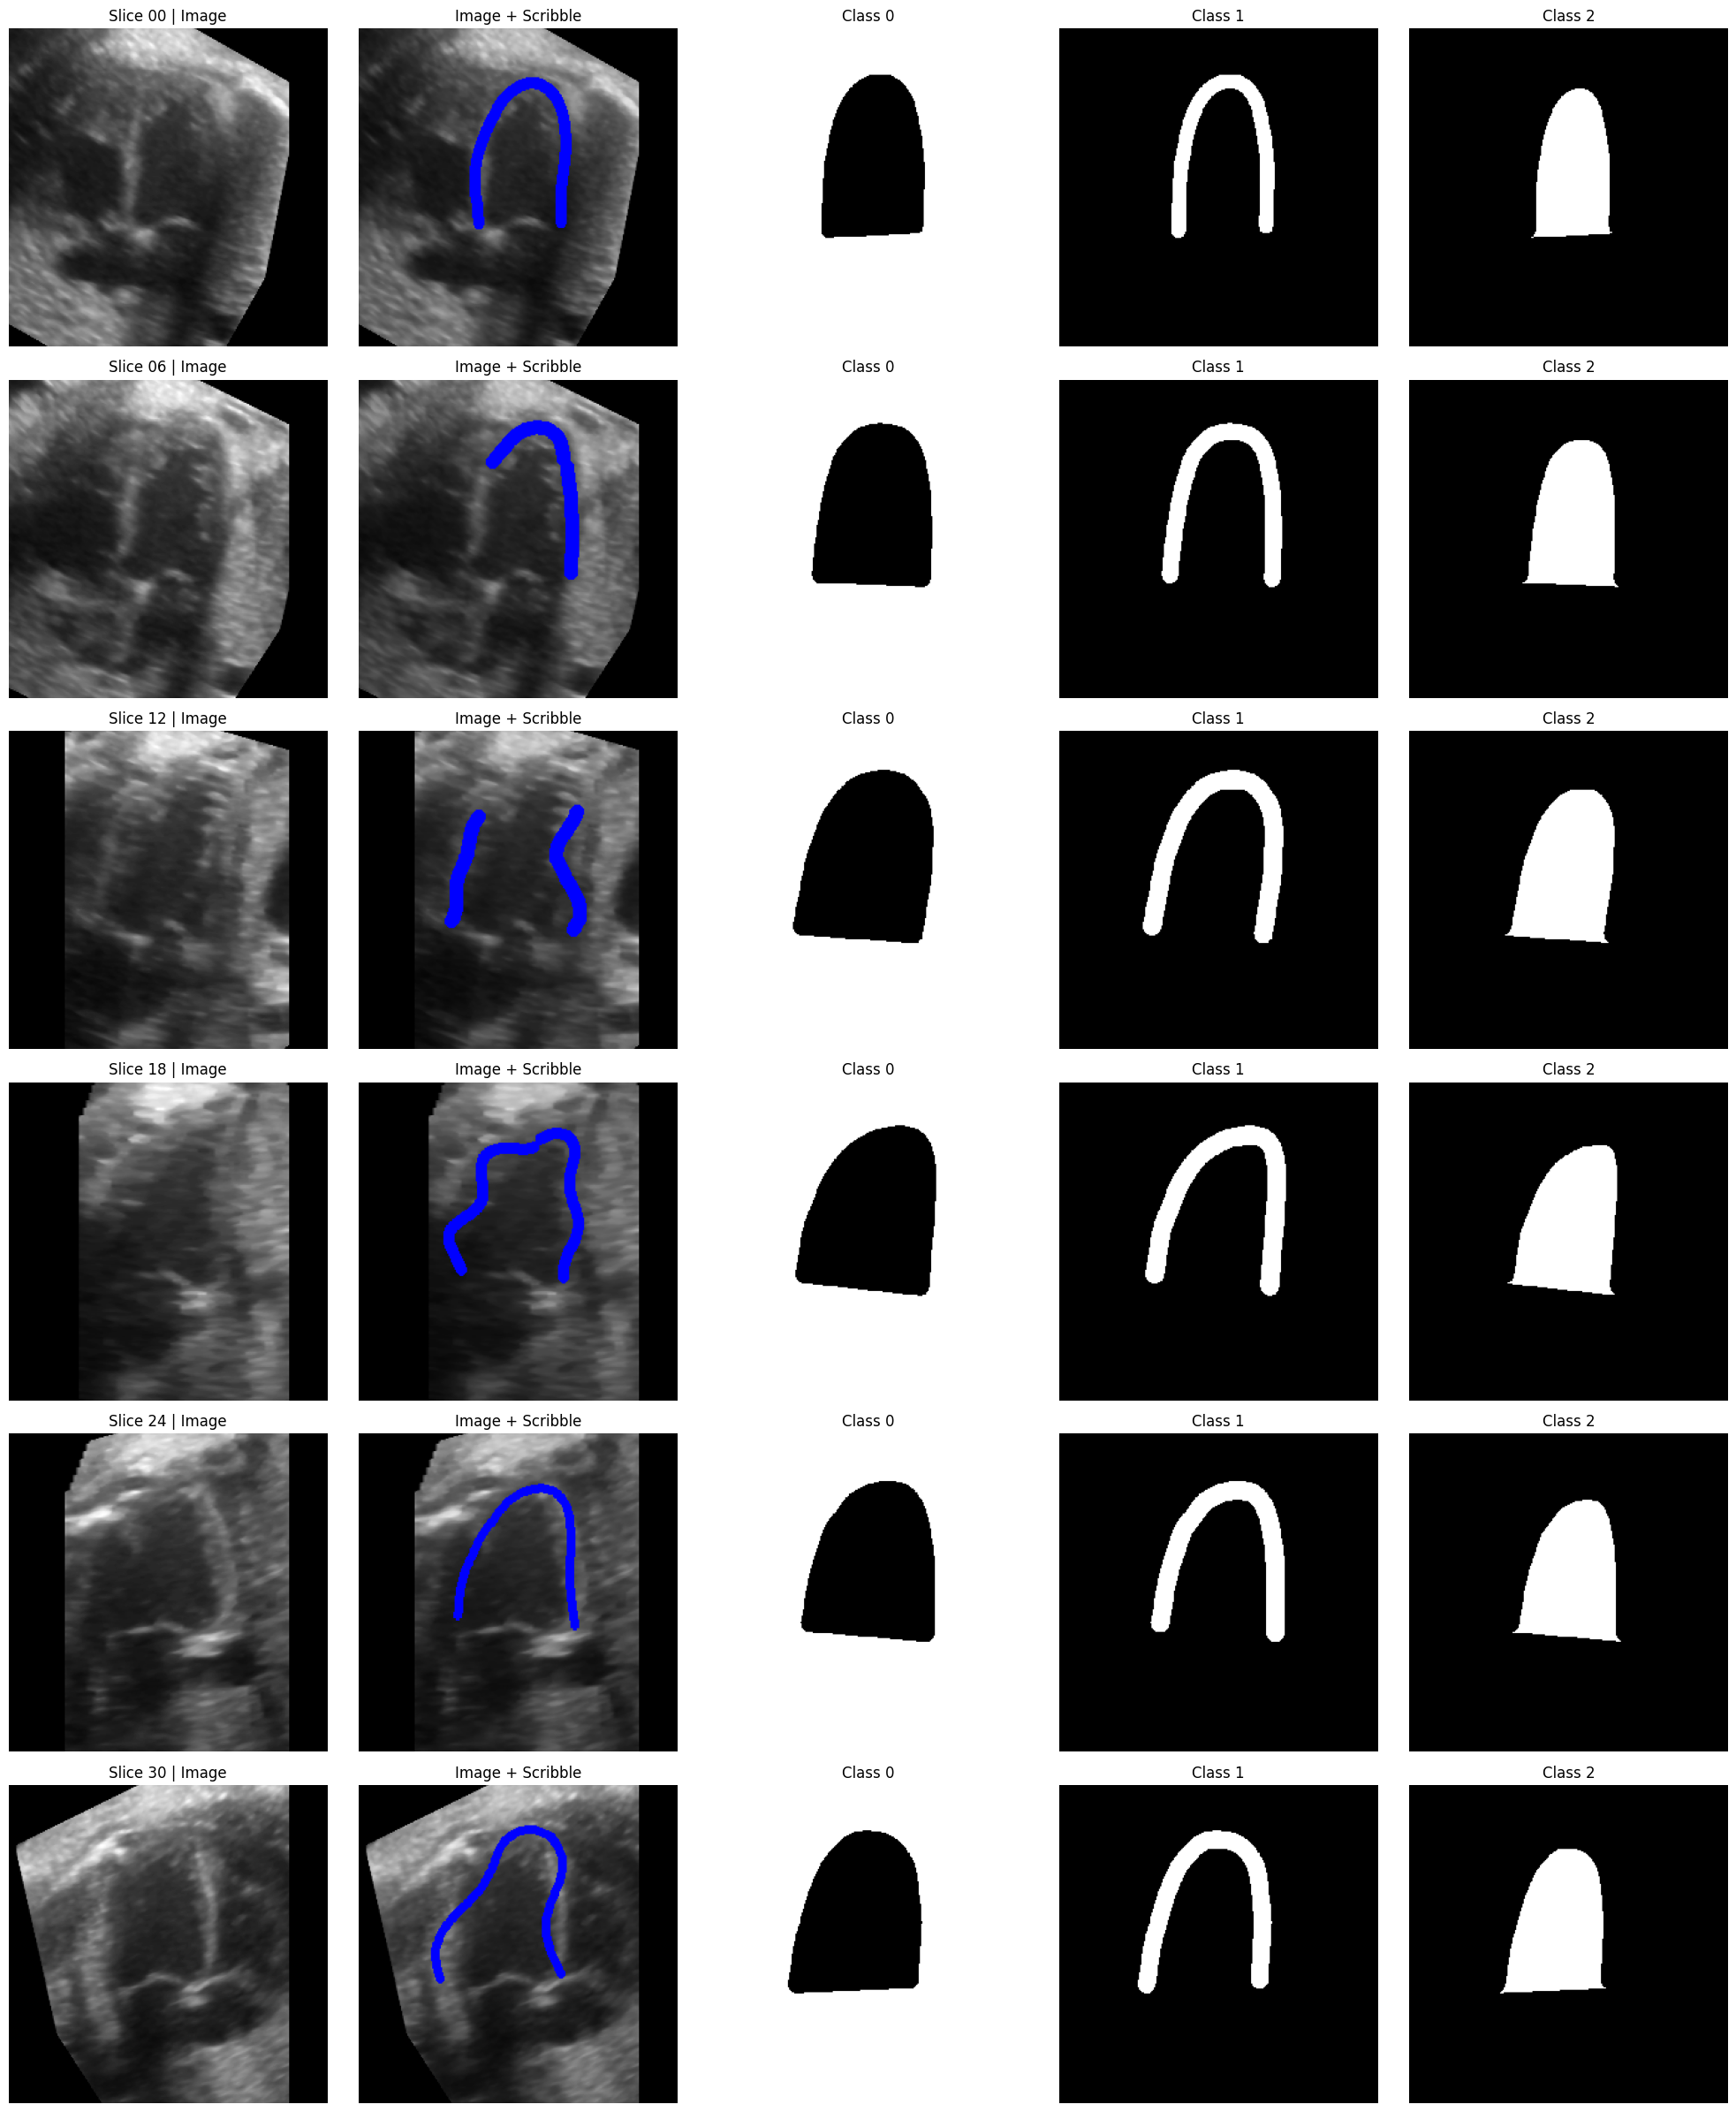

In [14]:
# -------------------------------------------------------------------
# Example: visualize scribble annotations for validation data
# -------------------------------------------------------------------

# Get the first batch from the validation loader
batch = next(iter(val_loader_MIX))   # Could also use: batch = first(val_loader_MIX)

# Print the filename of the first slice in the first volume of the batch
print(batch['name'][0][0])

# -------------------------------------------------
# Visualization #1: Single spatial slice across all time frames
#   - slice_idx=0 → show the same radial slice index (0) for each time frame
#   - num_classes=config.num_classes → number of segmentation classes
#   - device=device → used for one-hot encoding inside the visualization function
# -------------------------------------------------
show_time_slices_scribble(
    batch=batch,
    slice_idx=0,
    num_classes=config.num_classes,
    device=device
)

# -------------------------------------------------
# Visualization #2: Multiple spatial slices from a single time frame
#   - volume_idx=0 → fix to the first time frame (T0) in the batch
#   - slice_indices=[0, 6, 12, 18, 24, 30] → subset of available slices (0–36)
# -------------------------------------------------
show_slices_scribble(
    batch=batch,
    volume_idx=0,                        # Pick one time frame to display
    slice_indices=[0, 6, 12, 18, 24, 30], # Select subset of slice IDs
    num_classes=config.num_classes,
    device=device
)


In [15]:
class PositionEmbeddingRandom(nn.Module):
    """
    SAM-style random Fourier positional encoding.

    This creates a fixed, random Gaussian projection matrix and uses
    sine/cosine embeddings (similar to random Fourier features) to 
    encode (x, y) pixel coordinates.

    Args:
        num_pos_feats (int): Number of features per coordinate axis.
                             Output channels will be 2 * num_pos_feats (sin + cos).
        scale (float): Scaling factor applied to the random projection matrix.
    """
    def __init__(self, num_pos_feats: int = 64, scale: float = 1.0):
        super().__init__()
        self.register_buffer(
            "positional_encoding_gaussian_matrix",
            scale * torch.randn((2, num_pos_feats))  # [xy, num_pos_feats]
        )

    def _pe_encoding(self, coords: torch.Tensor) -> torch.Tensor:
        """
        Encode normalized coords ∈ [-1, 1] with sin/cos random features.
        Args:
            coords: Tensor of shape [N, 2] (x, y) normalized coordinates.
        Returns:
            Tensor of shape [N, 2*num_pos_feats] (sin and cos concatenated).
        """
        coords = 2 * coords - 1                                  # map [0,1] → [-1,1]
        coords = coords @ self.positional_encoding_gaussian_matrix  # linear projection
        coords = 2 * torch.pi * coords
        return torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1)

    def forward(self, size: Tuple[int, int]) -> torch.Tensor:
        """
        Create a full [C, H, W] positional encoding map.
        Args:
            size: (H, W) output resolution.
        Returns:
            Positional encoding tensor [C, H, W].
        """
        h, w = size
        device = self.positional_encoding_gaussian_matrix.device

        # Create normalized coordinate grids
        grid_y = torch.arange(h, device=device).float() + 0.5
        grid_x = torch.arange(w, device=device).float() + 0.5
        y_embed = grid_y[:, None].repeat(1, w) / h
        x_embed = grid_x[None, :].repeat(h, 1) / w
        coords = torch.stack([x_embed, y_embed], dim=-1)  # [H, W, 2]

        # Encode and reshape to [C, H, W]
        return self._pe_encoding(coords.view(-1, 2)).view(h, w, -1).permute(2, 0, 1)


class ScribblePositionEncoder(nn.Module):
    """
    Converts binary scribble masks into dense prompt embeddings 
    for integration into vision models.

    Workflow:
      1. Downsample scribble mask to match feature map resolution.
      2. Add random Fourier positional encoding (PE).
      3. Add a learned "scribble token" embedding at scribble locations.
      4. Smooth with small CNN.

    Args:
        embed_dim (int): Output embedding channel dimension.
        image_size (H_img, W_img): Original input image size.
        feature_size (H_feat, W_feat): Target feature map size to align with backbone.
    """
    def __init__(
        self,
        embed_dim: int = 256,
        image_size: Tuple[int, int] = (1024, 1024),
        feature_size: Tuple[int, int] = (64, 64)
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.image_size = image_size
        self.feature_size = feature_size

        # Positional encoding (random Fourier features)
        self.pe_layer = PositionEmbeddingRandom(embed_dim // 2)

        # Learned scribble token (single class: scribble foreground)
        self.scribble_embed = nn.Embedding(1, embed_dim)

        # Small CNN to smooth/aggregate encoded scribble features
        self.conv = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim, embed_dim, 3, padding=1)
        )

    def forward(self, scribbles: torch.Tensor) -> torch.Tensor:
        """
        Args:
            scribbles: [B, 1, H_img, W_img] binary mask (values {0,1} or {0,255}).
        Returns:
            Tensor [B, embed_dim, H_feat, W_feat]: dense prompt encoding.
        """
        B, _, H_img, W_img = scribbles.shape
        H_feat, W_feat = self.feature_size
        device = scribbles.device

        # Sanity check: enforce valid binary mask values
        unique_vals = torch.unique(scribbles)
        if not torch.all((unique_vals == 0) | (unique_vals == 1) | (unique_vals == 255)):
            raise ValueError(
                f"Scribble mask must contain only 0, 1, or 255 — found {unique_vals.tolist()}"
            )

        # Normalize mask to float [0,1]
        if scribbles.max() > 1:
            scribbles = (scribbles > 0).float()  # Convert 0/255 to 0.0/1.0
        else:
            scribbles = scribbles.float()

        # Downsample to match feature resolution
        scrib_down = F.interpolate(scribbles, size=(H_feat, W_feat), mode="nearest")

        # Positional encoding map [C, H_feat, W_feat]
        pe = self.pe_layer(self.feature_size).to(device)
        pe = pe.unsqueeze(0).expand(B, -1, -1, -1)  # Broadcast to batch

        # Learned scribble token embedding [1, C, 1, 1]
        token = self.scribble_embed.weight.view(1, -1, 1, 1)

        # Combine PE and token at scribble locations
        encoded = pe * scrib_down + token * scrib_down

        # Smooth/aggregate features
        return self.conv(encoded)


In [16]:
class ConvolutionalBlock(nn.Module):
    """
    Standard double-convolution block:
        Conv → BatchNorm → ReLU → Conv → BatchNorm → ReLU
    Preserves spatial resolution (padding=1 for 3×3 kernels).
    """
    def __init__(self, input_channels, output_channels):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(output_channels)
        
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(output_channels)
        
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        
        return x


class ResidualBlock(nn.Module):
    """
    Two-convolution residual block with optional channel-matching skip path.
    Structure:
        Conv → BN → ReLU → Conv → BN → (Add skip) → ReLU

    If input and output channels differ, a 1×1 Conv+BN is applied
    on the skip connection to match dimensions.
    """
    def __init__(self, input_channels: int, output_channels: int):
        super().__init__()

        # Main path
        self.conv1 = nn.Conv2d(input_channels, output_channels,
                               kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(output_channels)

        self.conv2 = nn.Conv2d(output_channels, output_channels,
                               kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(output_channels)

        # Skip path: identity if same channels, else 1×1 Conv+BN
        self.skip = (
            nn.Identity() if input_channels == output_channels else
            nn.Conv2d(input_channels, output_channels, kernel_size=1, bias=False)
        )
        self.skip_bn = (
            nn.Identity() if input_channels == output_channels else
            nn.BatchNorm2d(output_channels)
        )

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        # Skip connection (possibly channel-adjusted)
        identity = self.skip_bn(self.skip(x))

        # Main path
        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Residual addition
        out += identity
        out = self.act(out)
        return out


class EncoderBlock(nn.Module):
    """
    Encoder stage:
      - Residual block for feature extraction
      - Max pooling to downsample by factor 2

    Returns:
        feature_map        : output of conv block (for skip connection)
        pooled_feature_map : downsampled features (to next encoder stage)
    """
    def __init__(self, input_channels, output_channels):
        super().__init__()
        
        self.conv_block = ResidualBlock(input_channels, output_channels)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        feature_map = self.conv_block(x)
        pooled_feature_map = self.pooling(feature_map)
        return feature_map, pooled_feature_map


class DecoderBlock(nn.Module):
    """
    Decoder stage:
      - Transposed convolution to upsample by factor 2
      - Concatenate with corresponding encoder skip connection
      - Residual block for feature refinement
    """
    def __init__(self, input_channels, output_channels):
        super().__init__()
        
        self.upsample = nn.ConvTranspose2d(
            input_channels, output_channels, kernel_size=2, stride=2
        )
        # After concatenation: output_channels (upsampled) + output_channels (skip)
        self.conv_block = ResidualBlock(output_channels * 2, output_channels)

    def forward(self, x, skip_connection):
        # Upsample decoder features
        x = self.upsample(x)

        # Concatenate with encoder features (skip connection)
        x = torch.cat([x, skip_connection], dim=1)

        # Apply convolutional refinement
        x = self.conv_block(x)
        return x


In [17]:
from FlipConsistentAttention import *

class SCOPENet(nn.Module):
    def __init__(self, num_input_channels, num_classes, feature_sizes=[64, 128, 256, 512, 1024]):
        super().__init__()

        # -------------------------
        # Encoder path (downsampling)
        # -------------------------
        self.encoder1 = EncoderBlock(num_input_channels, feature_sizes[0])  # C → 64
        self.encoder2 = EncoderBlock(feature_sizes[0], feature_sizes[1])    # 64 → 128
        self.encoder3 = EncoderBlock(feature_sizes[1], feature_sizes[2])    # 128 → 256
        self.encoder4 = EncoderBlock(feature_sizes[2], feature_sizes[3])    # 256 → 512
        self.bottleneck = ResidualBlock(feature_sizes[3], feature_sizes[4]) # 512 → 1024 (no pooling)

        # Flip-consistent attention over radial slices (operates on [B,S,C,H,W])
        self.attentions = FCRA(dim=feature_sizes[4])

        # -------------------------
        # Scribble prompt encoder
        # -------------------------
        self.scribble_encoder = ScribblePositionEncoder(
            embed_dim=feature_sizes[4],         # 1024 channels to match bottleneck
            image_size=(256, 256),              # original image size (for reference)
            feature_size=(16, 16)               # target feature map size for prompts
        )

        # -------------------------
        # Decoder path (upsampling)
        # -------------------------
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(feature_sizes[i + 1], feature_sizes[i])  # 1024→512, 512→256, 256→128, 128→64
            for i in range(len(feature_sizes) - 1)
        ])

        # Final 1×1 conv to produce class logits; Softmax for probabilities
        self.classifier = nn.Conv2d(feature_sizes[0], num_classes, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x, scribble):
        """
        Args:
            x:        [B, S, C, H, W]  volume of slices per sample
            scribble: [B, S, C, H, W]  scribble masks aligned with x
                                       (NOTE: scribble encoder expects a single-channel mask per slice;
                                        here 'C' should effectively be 1 for scribbles.)
        Returns:
            segmentation_mask: [B, S, num_classes, H, W]
            bottleneck_feats : [B, S, C_bottleneck, H', W'] features before decoder
        """
        B, S, C, H, W = x.shape

        # Flatten temporal/slice dimension into batch for 2D encoders
        x = x.view(B * S, C, H, W)                     # [B*S, C, H, W]
        scribble = scribble.view(B * S, C, H, W)       # [B*S, C, H, W]

        # -------------------------
        # Encoder forward (with skips)
        # -------------------------
        skip1, p1 = self.encoder1(x)                   # skip1: [B*S, 64,  H,   W  ], p1: [B*S, 64,  H/2,  W/2]
        skip2, p2 = self.encoder2(p1)                  # skip2: [B*S, 128, H/2, W/2], p2: [B*S, 128, H/4,  W/4]
        skip3, p3 = self.encoder3(p2)                  # skip3: [B*S, 256, H/4, W/4], p3: [B*S, 256, H/8,  W/8]
        skip4, p4 = self.encoder4(p3)                  # skip4: [B*S, 512, H/8, W/8], p4: [B*S, 512, H/16, W/16]
        bottleneck = self.bottleneck(p4)               # [B*S, 1024, H/16, W/16]

        # Flip-consistent attention across S (reshape to [B,S,C,H',W'])
        bottleneck = self.attentions(
            bottleneck.reshape(B, S, *bottleneck.shape[1:])
        ).reshape(B * S, *bottleneck.shape[1:])        # back to [B*S, 1024, H/16, W/16]

        # Encode scribble prompt at feature resolution
        scribble_prompt = self.scribble_encoder(scribble)  # [B*S, 1024, H/16, W/16]

        # Save bottleneck feats per [B,S,...] for possible analysis/outputs
        bottleneck_feats = bottleneck.view(B, S, *bottleneck.shape[1:])  # [B, S, 1024, H/16, W/16]

        # Modulate bottleneck with scribble prompt (elementwise)
        bottleneck = bottleneck * scribble_prompt         # [B*S, 1024, H/16, W/16]

        # -------------------------
        # Decoder forward (skip connections)
        # Notes:
        #   skip4, skip3, skip2, skip1 correspond to encoder stages 4→1
        #   decoded progressively returns to input spatial size
        # -------------------------
        decoded = self.decoder_blocks[3](bottleneck, skip4)  # 1024→512, concat with skip4 → ResidualBlock
        decoded = self.decoder_blocks[2](decoded,   skip3)   # 512→256
        decoded = self.decoder_blocks[1](decoded,   skip2)   # 256→128
        decoded = self.decoder_blocks[0](decoded,   skip1)   # 128→64

        # -------------------------
        # Segmentation head
        # -------------------------
        segmentation_mask = self.classifier(decoded)          # [B*S, num_classes, H, W]
        segmentation_mask = self.softmax(segmentation_mask)   # probabilities per class (optional for training)

        # Restore [B, S, num_classes, H, W]
        segmentation_mask = segmentation_mask.view(B, S, self.classifier.out_channels, H, W)

        return segmentation_mask, bottleneck_feats


In [18]:
# Instantiate the SCOPENet segmentation model
#   - num_classes: number of segmentation classes (including background)
#   - num_input_channels: number of input channels per slice (e.g., 1 for grayscale)
model = SCOPENet(
    num_classes=config.num_classes,
    num_input_channels=1
)


In [19]:
class DiceIoU(nn.Module):
    """ Computes Dice coefficient and Intersection over Union (IoU) for each class separately. """
    def __init__(self, num_classes, smooth=1e-5):
        super().__init__()
        self.num_classes = num_classes         # number of semantic classes (incl. background)
        self.smooth = smooth                   # epsilon to avoid zero-division

    def forward(self, predictions, targets):
        """ Computes Dice coefficient and IoU for each class. 
        
        Args:
        - predictions: Tensor of shape (B, S, C, H, W) or (B, C, H, W) -> per-class probabilities.
        - targets    : Tensor of shape (B, S, C, H, W) or (B, C, H, W) -> one-hot ground truth.

        Returns:
        - dice_scores: List of Dice scores (scalar tensors), length = num_classes.
        - iou_scores : List of IoU scores  (scalar tensors), length = num_classes.
        """
        dice_scores = []                       # will collect per-class Dice
        iou_scores  = []                       # will collect per-class IoU
        
        for class_idx in range(self.num_classes):
            # Select the class channel across batch / (optional) time / spatial dims
            class_prediction = predictions[:, :, class_idx, :, :]  # prob map for class k
            class_target     = targets[:,     :, class_idx, :, :]  # one-hot GT for class k
            
            # Intersection and (soft) union across all dims
            intersection = torch.sum(class_prediction * class_target)     # overlap
            total_sum    = torch.sum(class_prediction) + torch.sum(class_target)
            union        = total_sum - intersection                       # |A ∪ B| = |A|+|B|-|A∩B|
            
            # Dice = (2|A∩B|) / (|A|+|B|)
            dice_score = (2. * intersection + self.smooth) / (total_sum + self.smooth)
            dice_scores.append(dice_score)

            # IoU = |A∩B| / |A∪B|
            iou_score = (intersection + self.smooth) / (union + self.smooth)
            iou_scores.append(iou_score)
        
        return dice_scores, iou_scores



class DiceLoss(nn.Module):
    """ Computes the Dice loss for multi-class segmentation (averaged over classes, excluding background). """
    def __init__(self, num_classes, smooth=1e-5):
        super().__init__()
        self.num_classes = num_classes         # total classes (assume class 0 is background)
        self.smooth = smooth                   # epsilon for numerical stability

    def forward(self, predictions, targets):
        """ Computes the Dice loss, averaging across all classes (excluding background). """
        dice_losses = []                       # collect 1 - Dice for each foreground class
        for class_idx in range(1, self.num_classes):  # Skip background (index 0)
            class_prediction = predictions[:, :, class_idx, :, :]  # predicted prob map for class
            class_target     = targets[:,     :, class_idx, :, :]  # one-hot GT for class

            # Dice components
            intersection = torch.sum(class_prediction * class_target)
            union        = torch.sum(class_prediction) + torch.sum(class_target)
            dice_score   = (2. * intersection + self.smooth) / (union + self.smooth)
            
            dice_loss = 1. - dice_score        # Dice loss
            dice_losses.append(dice_loss)
        
        return torch.mean(torch.stack(dice_losses))  # mean over foreground classes


# Define loss functions (module instances)
cross_entropy_loss = nn.CrossEntropyLoss()                 # per-pixel multi-class CE on logits
dice_multiclass    = DiceIoU(num_classes=config.num_classes)
dice_loss_fn       = DiceLoss(num_classes=config.num_classes)


def symmetry_consistency_loss(f: torch.Tensor, mode: str = 'l1', margin: float = 0.9) -> torch.Tensor:
    """
    Generic symmetry consistency loss.
    Enforces: f[:, θ] ≈ flip_W( f[:, π−θ] )

    Args:
        f      : [B, S, C, H, W] tensor (e.g., bottleneck features or logits).
        mode   : one of {'l1', 'cosine', 'margin'} controlling the penalty type.
        margin : used only with 'margin' mode; target minimum cosine similarity.

    Returns:
        Scalar tensor: symmetry-consistency penalty.
    """
    # Flip across angle θ → π−θ  (reverse slice order)
    f_flip = torch.flip(f, dims=[1])            # flip angular dimension S

    # Then flip across width (left–right) to align mirrored content
    f_flip = torch.flip(f_flip, dims=[-1])      # flip width W

    if mode == 'l1':
        return F.l1_loss(f, f_flip)             # mean absolute deviation

    elif mode == 'cosine':
        # Normalize flattened features per (B,S) before cosine similarity
        f_flat      = F.normalize(f.view(f.shape[0], f.shape[1], -1),      dim=-1)  # [B, S, C*H*W]
        f_flip_flat = F.normalize(f_flip.view(f.shape[0], f.shape[1], -1), dim=-1)
        sim = F.cosine_similarity(f_flat, f_flip_flat, dim=-1)                       # [B, S]
        return 1 - sim.mean()                   # penalize low similarity

    elif mode == 'margin':
        # Hinge-like margin on cosine similarity
        f_flat      = F.normalize(f.view(f.shape[0], f.shape[1], -1),      dim=-1)
        f_flip_flat = F.normalize(f_flip.view(f.shape[0], f.shape[1], -1), dim=-1)
        sim = F.cosine_similarity(f_flat, f_flip_flat, dim=-1)                       # [B, S]
        return torch.clamp(margin - sim, min=0).mean()

    else:
        raise ValueError(f"Unsupported mode: {mode}. Use 'l1', 'cosine', or 'margin'.")


def compute_loss(prediction, target, feats, device, λ_sym: float = 0.1):
    """
    Compute total training loss.

    Components:
      • Dice loss on predicted segmentation (via argmax → one-hot).
      • Cross-entropy loss against sparse labels.
      • Symmetry-consistency loss on features/logits.

    Args:
        prediction : [B, S, C, H, W] model outputs (C=num_classes).
                     CrossEntropyLoss expects **logits**; if Softmax was applied in the model,
                     consider passing pre-Softmax logits instead for CE stability.
        target     : [B, S, 1, H, W] integer class labels.
        feats      : [B, S, C_f, H_f, W_f] feature map used for symmetry loss.
        device     : torch.device for one-hot encoding.
        λ_sym      : weight for symmetry loss term.

    Returns:
        total_loss : scalar tensor
        dice_scores: list of per-class Dice (as scalars)
        IoU        : list of per-class IoU   (as scalars)
        symm_loss  : scalar symmetry penalty
    """
    # Convert network predictions to hard labels via argmax over class dim (dim=2 here)
    segmented_predictions = torch.argmax(prediction, dim=2).unsqueeze(2).float()  # [B,S,1,H,W]

    # Dice loss on one-hot encodings (predictions vs. targets)
    dice_loss = dice_loss_fn(
        make_one_hot(target, device, C=config.num_classes),
        make_one_hot(segmented_predictions, device, C=config.num_classes)
    ).requires_grad_(True)  # keep graph if needed

    # Report per-class Dice / IoU (for logging/metrics)
    dice_scores, IoU = dice_multiclass(
        make_one_hot(target, device, C=config.num_classes),
        make_one_hot(segmented_predictions, device, C=config.num_classes)
    )

    # Cross-entropy on sparse labels:
    #   reshape to merge B and S so CE sees [N, C, H, W] vs. [N, H, W]
    ce_logits = prediction.view(-1, prediction.size(2), prediction.size(3), prediction.size(4))  # [B*S, C, H, W]
    ce_target = target.view(-1, target.size(3), target.size(4)).long()                           # [B*S, H, W]
    cross_entropy = cross_entropy_loss(ce_logits, ce_target)

    # Symmetry consistency penalty on features/logits (cosine mode by default)
    symm_loss = symmetry_consistency_loss(feats, mode='cosine')

    # Total loss as weighted sum
    total_loss = dice_loss + cross_entropy + λ_sym * symm_loss
    
    return total_loss, dice_scores, IoU, symm_loss


In [20]:
model = model.to(device)                          # Move model to GPU/CPU
# model = nn.DataParallel(model)                  # (Optional) multi-GPU wrapper
optimizer = torch.optim.Adam(                     # Adam optimizer for all trainable params
    model.parameters(), lr=config.LR, weight_decay=1e-5
)

def choose_loader(epoch, total_epochs, verbose=True):
    """
    Choose between mixed (random) loader and temporal neighbor loader.
    Phase schedule:
      - First T1 epochs → MIX loader (higher diversity).
      - Remaining epochs → no-MIX loader (temporal windows preserved).
    """
    T1 = int(total_epochs * 1.0)                  # Here: always MIX for all epochs (as written)

    if epoch < T1:
        if verbose:
            print(f"[Epoch {epoch:03d}] – using MIX loader")
        return train_loader_MIX                    # Phase-1 (diverse shuffling)
    else:
        if verbose:
            print(f"[Epoch {epoch:03d}] – using no-MIX loader")
        return train_loader_noMIX                  # Phase-2+ (temporal windows)

# ---- Automatic Mixed Precision (AMP) setup ----
fp16_precision = True                              # Enable autocast for speed/memory
scaler = GradScaler(enabled=fp16_precision)        # Gradient scaler for AMP stability

# ---- Best checkpoint tracking ----
max_val_lesion_dice = 0
best_epoch = 0

# ---- Excel logging setup ----
summary_path = saveFile + ".xlsx"
columns = ['Epoch', 'Train Loss', 'Val Loss', 'Train MYO Dice', 'Val MYO Dice', 'Train LV Dice', 'Val LV Dice']

if not os.path.exists(summary_path):
    wb = Workbook()
    ws = wb.active
    ws.append(columns)                             # Write header row
    wb.save(summary_path)

# ======================
# Training / Validation loop
# ======================
for epoch in range(config.num_epochs):
    # === Training ===
    model.train()
    train_loss = 0.0
    epoch_train_MYO_dice = 0.0
    epoch_train_LV_dice  = 0.0
    batch_count = 0

    loader = choose_loader(epoch, config.num_epochs, verbose=True)  # Select train loader phase
    train_loop = tqdm(loader, desc=f"Train Epoch {epoch+1}/{config.num_epochs}", leave=True)

    for batch_data in train_loop:
        batch_count += 1
        images   = batch_data['image'].to(device)     # [B,S,1,H,W]
        masks    = batch_data['mask'].to(device)      # [B,S,1,H,W] (integer labels per pixel)
        scribble = batch_data['scribble'].to(device)  # [B,S,1,H,W] (binary prompt)

        optimizer.zero_grad()
        with autocast(enabled=fp16_precision):        # Forward in mixed precision
            predictions, features = model(images, scribble)   # predictions: [B,S,C,H,W], features: [B,S,Cb,Hf,Wf]
            loss, dice_scores, _, symm_losss = compute_loss(  # total loss + per-class Dice + symmetry loss
                predictions, masks, features, device
            )

        # AMP backward & optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        train_loss += loss.item()
        epoch_train_MYO_dice += dice_scores[1].item()  # assumes class-1 = MYO
        epoch_train_LV_dice  += dice_scores[2].item()  # assumes class-2 = LV

        # Live progress bar metrics
        train_loop.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Symm_losss": f"{symm_losss.item():.4f}",
            "MYO Dice": f"{dice_scores[1]:.4f}",
            "LV Dice": f"{dice_scores[2]:.4f}"
        })

    # === Validation ===
    model.eval()
    val_loss = 0.0
    epoch_val_MYO_dice = 0.0
    epoch_val_LV_dice  = 0.0
    val_batch_count = 0

    val_loop = tqdm(val_loader_MIX, desc=f"Val Epoch {epoch+1}/{config.num_epochs}", leave=True)
    with torch.no_grad():                            # Disable grad for validation
        for batch_data in val_loop:
            val_batch_count += 1
            images   = batch_data['image'].to(device)
            masks    = batch_data['mask'].to(device)
            scribble = batch_data['scribble'].to(device)

            with autocast(enabled=fp16_precision):
                predictions, features = model(images, scribble)
                loss, dice_scores, _, symm_losss = compute_loss(
                    predictions, masks, features, device
                )

            # Accumulate metrics
            val_loss += loss.item()
            epoch_val_MYO_dice += dice_scores[1].item()
            epoch_val_LV_dice  += dice_scores[2].item()

            # Live progress bar metrics (val)
            val_loop.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Symm_losss": f"{symm_losss.item():.4f}",
                "MYO Dice": f"{dice_scores[1]:.4f}",
                "LV Dice": f"{dice_scores[2]:.4f}"
            })

    # === Epoch averages ===
    avg_train_loss   = train_loss / max(1, batch_count)
    avg_val_loss     = val_loss   / max(1, val_batch_count)
    avg_train_MYO_dice = epoch_train_MYO_dice / max(1, batch_count)
    avg_val_MYO_dice   = epoch_val_MYO_dice  / max(1, val_batch_count)
    avg_train_LV_dice  = epoch_train_LV_dice / max(1, batch_count)
    avg_val_LV_dice    = epoch_val_LV_dice   / max(1, val_batch_count)
    avg_val_dice       = (avg_val_MYO_dice + avg_val_LV_dice) / 2.0

    # Save best checkpoint by mean validation Dice (MYO & LV)
    if avg_val_dice > max_val_lesion_dice:
        max_val_lesion_dice = avg_val_dice
        best_epoch = epoch + 1
        torch.save(model.state_dict(), checkpoint_path)
        print(f">>> Best model saved at Epoch {best_epoch} with Val Dice {avg_val_dice:.4f}")

    print()  # newline after epoch logs

    # === Append epoch metrics to Excel ===
    wb = load_workbook(summary_path)
    ws = wb.active
    ws.append([
        epoch + 1,
        avg_train_loss,
        avg_val_loss,
        avg_train_MYO_dice,
        avg_val_MYO_dice,
        avg_train_LV_dice,
        avg_val_LV_dice
    ])
    wb.save(summary_path)


[Epoch 000] – using MIX loader


Train Epoch 1/100:   0%|          | 1/370 [00:03<19:09,  3.11s/it, Loss=1.9514, Symm_losss=0.5391, MYO Dice=0.0377, LV Dice=0.0568]

In [ ]:
# Instantiate the UNet model and move it to the selected device
#   - num_classes: total classes in your segmentation (incl. background)
#   - num_input_channels: input channels per slice (1 = grayscale)
model = SCOPENet(
    num_classes=config.num_classes,
    num_input_channels=1
)
model = model.to(device)
model.eval()  # Evaluation mode: disables Dropout/BatchNorm updates

# Load trained weights from checkpoint
# map_location ensures the weights load correctly on the current device
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Create output directory for saving predictions/visualizations
if not os.path.exists(saveFile):
    os.makedirs(saveFile)

# Iterate over the test set
for batch_data in tqdm(test_loader_MIX):

    # Move batch tensors to device
    images   = batch_data['image'].to(device)     # [B, 37, 1, H, W]
    masks    = batch_data['mask'].to(device)      # [B, 37, 1, H, W]
    scribble = batch_data['scribble'].to(device)  # [B, 37, 1, H, W]

    # Forward pass (no grad needed, but eval() is already set)
    predictions, _ = model(images, scribble)      # predictions: [B, 37, C, H, W]

    # Convert probabilities/logits to hard labels via argmax over class dim (dim=2)
    masks_predictions = torch.argmax(predictions, dim=2).unsqueeze(2).to(torch.float32)  # [B, 37, 1, H, W]

    # Map class labels to visualization intensities for saving:
    #   class 1 → 200 (e.g., MYO), class 2 → 100 (e.g., LV)
    # NOTE: This changes the tensors in-place for saving images only.
    masks_predictions[masks_predictions == 1] = 200
    masks_predictions[masks_predictions == 2] = 100
    masks[masks == 1] = 200
    masks[masks == 2] = 100

    # Save per-slice images/masks for each item in the batch
    for slices in range(37):  # iterate over all radial slices
        for batch in range(masks_predictions.shape[0]):  # iterate over batch items

            # Extract numpy arrays for saving
            true_mask = masks[batch, slices, :, :, :].reshape(config.img_size, config.img_size).detach().cpu().numpy()
            pred_mask = masks_predictions[batch, slices, :, :, :].reshape(config.img_size, config.img_size).detach().cpu().numpy()
            true_img  = images[batch, slices, :, :, :].reshape(config.img_size, config.img_size).detach().cpu().numpy()

            # De-normalize image from [-1,1] back to [0,1] (assuming Normalize mean=0.5, std=0.5)
            true_img = true_img * 0.5 + 0.5

            # Build filenames from original paths:
            #   - use the slice-level filename, strip '.png', then append suffixes
            base_name = batch_data['name'][slices][0].split('/')[-1].replace('.png', '')

            # Save predicted mask, ground-truth mask, and input image
            cv2.imwrite(os.path.join(saveFile, f"{base_name}_pred_mask.png"), pred_mask)
            cv2.imwrite(os.path.join(saveFile, f"{base_name}_true_mask.png"), true_mask)
            cv2.imwrite(os.path.join(saveFile, f"{base_name}_true_img.png"), 255 * true_img)  # scale to 0–255

            # Uncomment to debug a single item/slice:
            # break
        # break
    # break
